In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")
    
import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from lime import lime_tabular

from preprocessing import preprocess
from cluster import *
from baseline import train_val_split, baseline_model

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
labels_path = '../labels/'
data_path = '../data/'
course = 'dsp_001'
path = data_path + course + '/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
hard_fail = path + 'feature_labels.csv'
percentile = 0.6

In [2]:
x_train, x_test, x_val, y_train, y_test, y_val, feature_names, patterns = preprocess(course, path, percentile, feature_types, metadata, hard_fail)

In [3]:
# Concat features & labels
X = np.concatenate([x_train, x_val, x_test], axis=0)
Y = np.concatenate([y_train, y_val, y_test], axis=0)
P = np.concatenate(patterns, axis=0)

In [4]:
labels_cluster_path = labels_path + 'spectral_clustering/'
labels = np.loadtxt(labels_cluster_path+'min_max_norm_baseline_cluster_labels_perc_0.6.txt', dtype=int)

In [5]:
def get_instance_explanations(c):
    idx = np.where(labels == c)[0]
    X_train = X[idx]
    Y_train = Y[idx]
    x_train, x_val, y_train, y_val = train_val_split(X_train, Y_train)

    baseline_params = {
    'name': 'baseline-32u-1l',
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['binary_accuracy'],
    'epochs': 20,
    'batch_size': 64,
    'verbose': 1
    }
    baseline = baseline_model()

    baseline.load_weights(MODEL_PATH + 'baseline_classifier_for_cluster_'+str(c)).expect_partial()

    predict_fn = lambda x: np.array([[1-baseline.predict(x)], [baseline.predict(x)]]).reshape(2,-1).T

    explainer = lime_tabular.RecurrentTabularExplainer(x_train, mode='classification',
                                                       class_names=['Pass', 'Fail'], 
                                                       training_labels=y_train, feature_names=feature_names,
                                                        )

    instances = random.sample([i for i in range(len(x_train))], 100)
    explainers = []
    for i in instances:
        exp=explainer.explain_instance(x_train[i], predict_fn, num_features=10, labels=(1,))
        explainers.append(exp)
    
    return explainers, instances, y_train

def pyplot_all(explainers, instances, real_labels):
    suffix = ['_t-5', '_t-4', '_t-3', '_t-2', '_t-1', '_t-0']
    for i, exp in enumerate(explainers):
        l = 'Fail' if real_labels[instances[i]] else 'Pass'
        label = exp.available_labels()[0]
        expl = exp.as_list(label=label)
        new_expl = []
        for e in expl:
            for j, s in enumerate(suffix):
                if e[0].find(s) != -1:
                    new_expl.append((e[0].replace(s, '_w-'+str(j)), e[1]))
                
        expl = new_expl
        vals = [x[1] for x in expl]
        names = [x[0] for x in expl]
        
        vals.reverse()
        names.reverse()
        colors = ['green' if x > 0 else 'red' for x in vals]
        pos = np.arange(len(expl)) + .5
        
        plt.barh(pos, vals, align='center', color=colors)
        plt.yticks(pos, names)
        if exp.mode == "classification":
            title = 'Local explanation for class %s for instance %d with real class %s' % (exp.class_names[label],instances[i],l)
        plt.title(title)
        plt.show()
        
def DataFrame_all(explainers,instances,real_labels):
    df=pd.DataFrame({})
    class_names=['Pass', 'Fail']
    dfl = []
    suffix = ['_t-5', '_t-4', '_t-3', '_t-2', '_t-1', '_t-0']
    for i,exp in enumerate(explainers):
        this_label = exp.available_labels()[0]
        l = []
        l.append(("exp number", instances[i]))
        l.append(("real value", 'Fail' if real_labels[instances[i]] else 'Pass'))
        expl = exp.as_list(label=this_label)
        new_expl = []
        for e in expl:
            for j, s in enumerate(suffix):
                if e[0].find(s) != -1:
                    new_expl.append((e[0].replace(s, '_w-'+str(j)), e[1]))
                
        expl = new_expl
        l.extend(expl)
        dfl.append(dict(l))
    df = df.append(pd.DataFrame(dfl))
    return df

## Cluster 0

In [6]:
explainers_0, instances_0, real_labels_0 = get_instance_explanations(0)

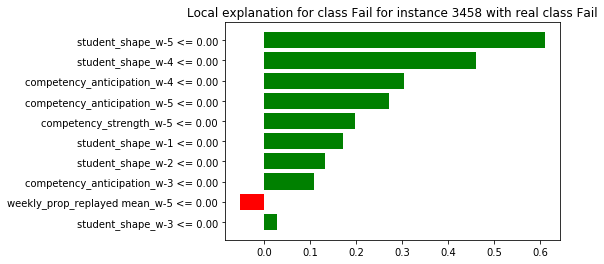

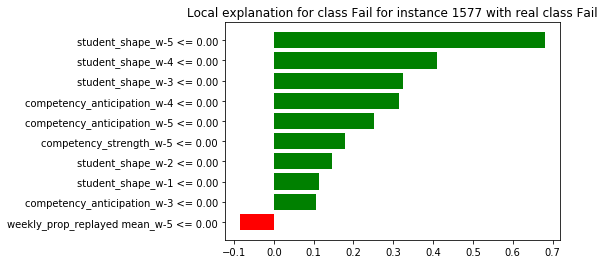

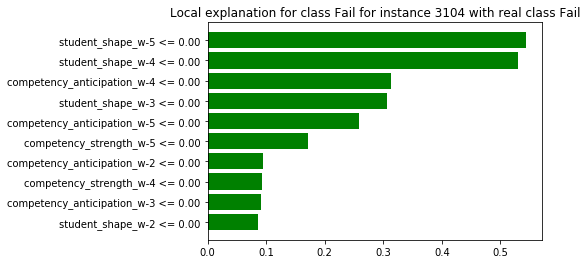

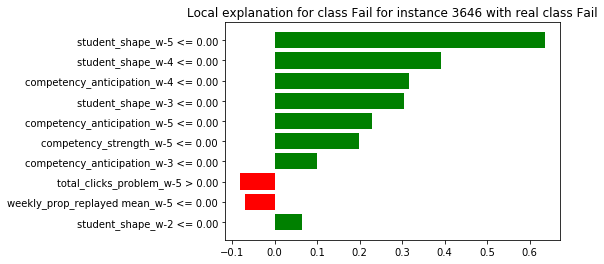

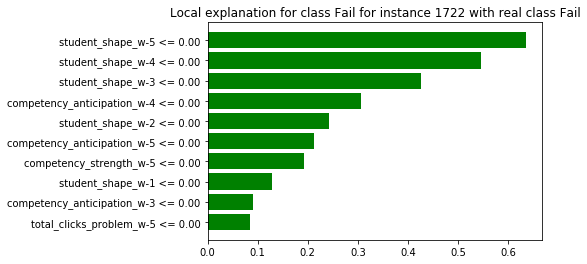

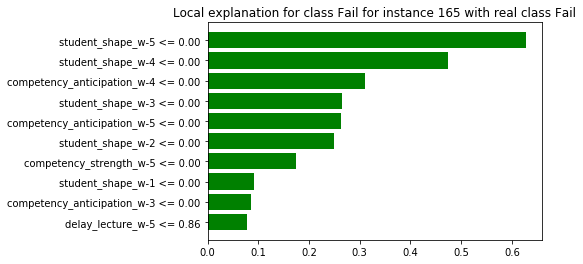

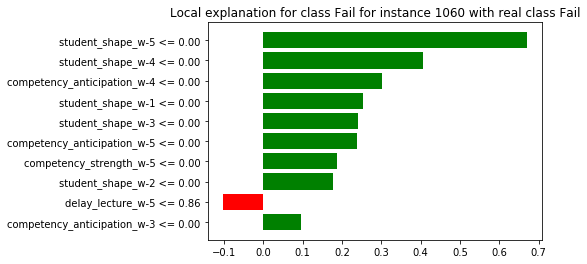

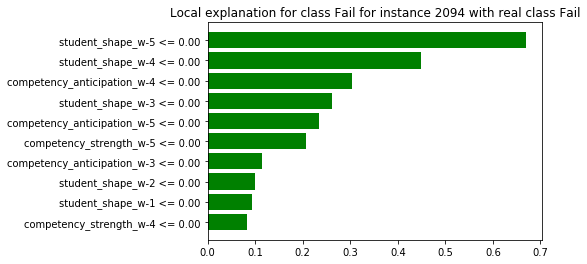

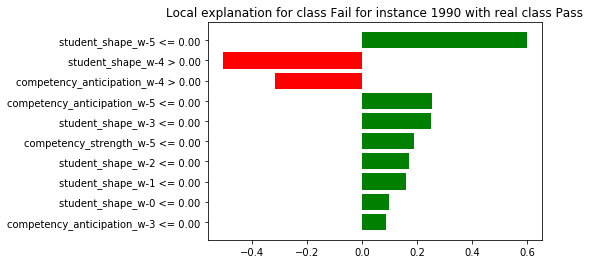

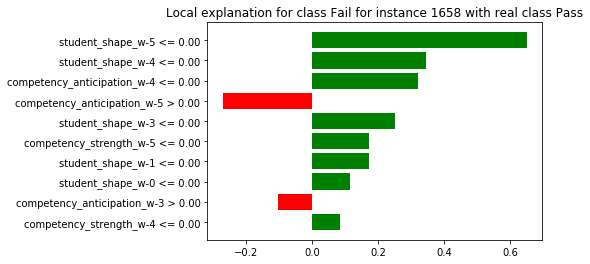

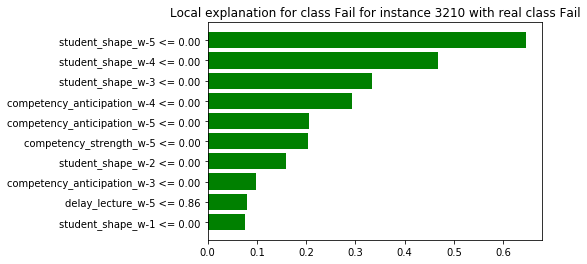

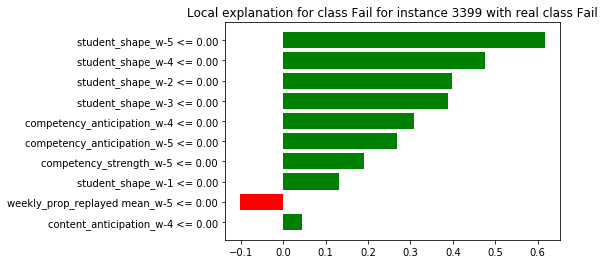

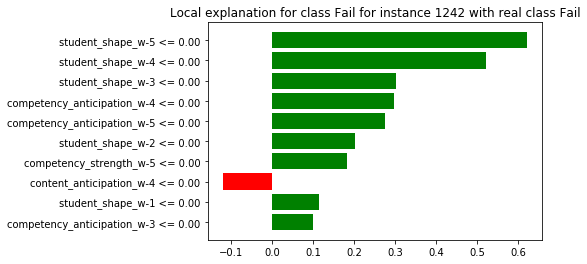

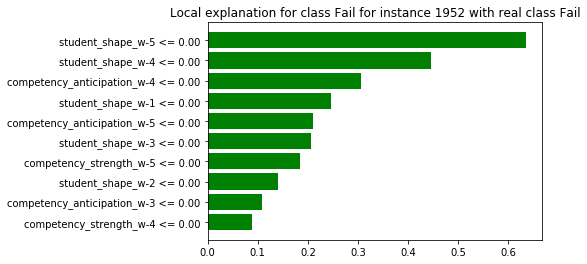

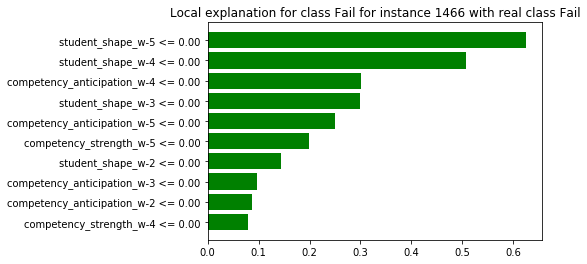

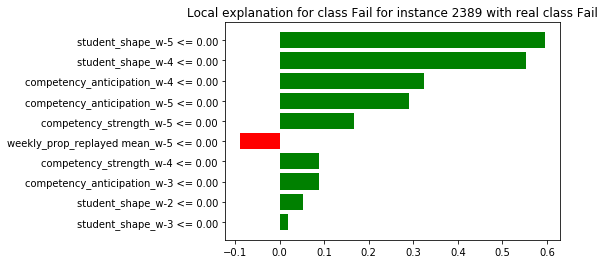

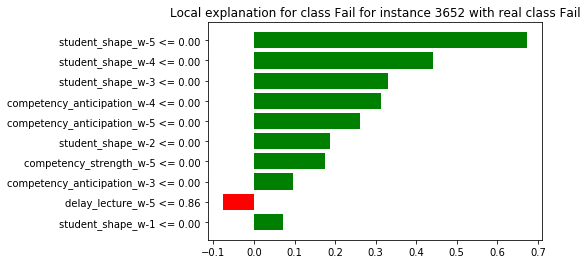

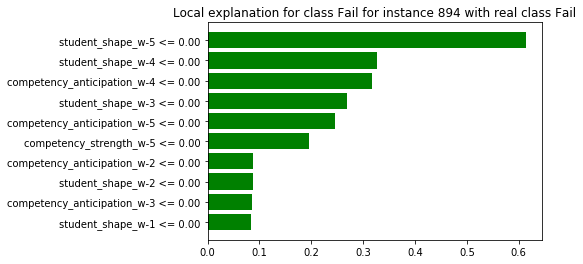

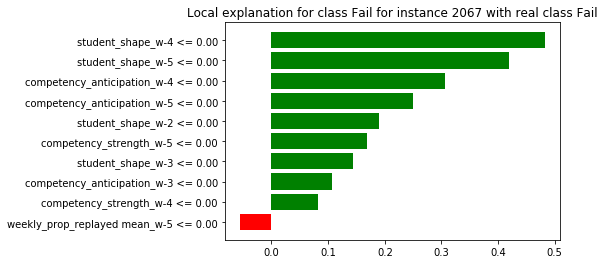

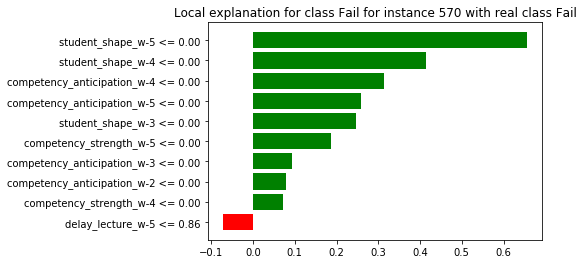

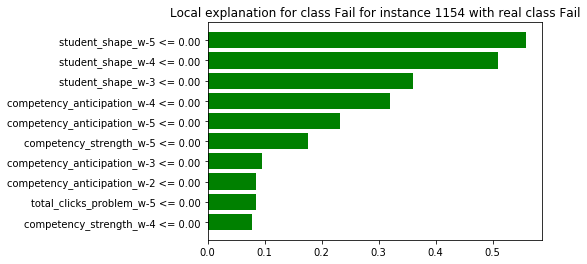

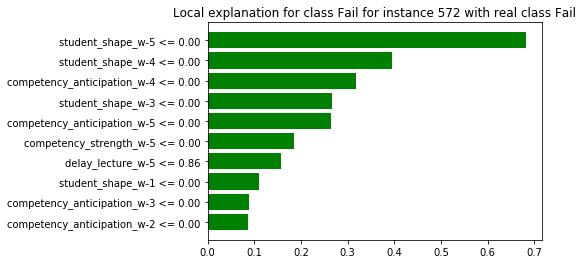

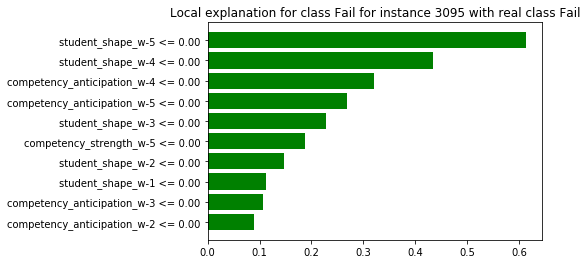

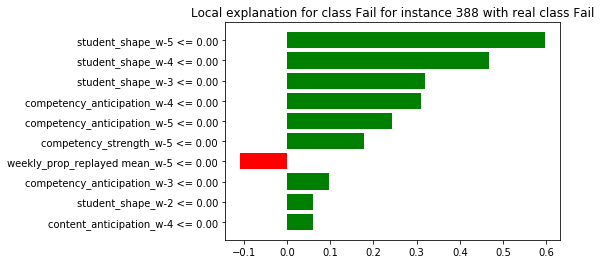

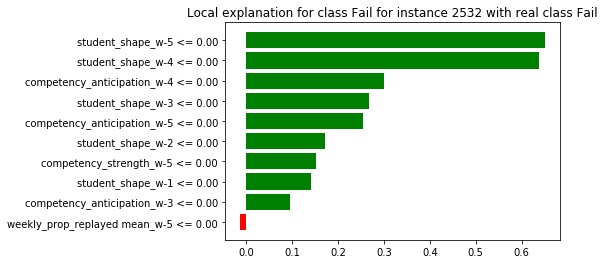

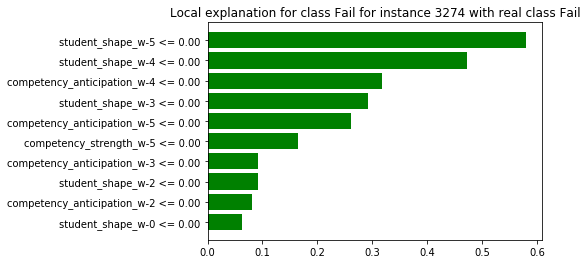

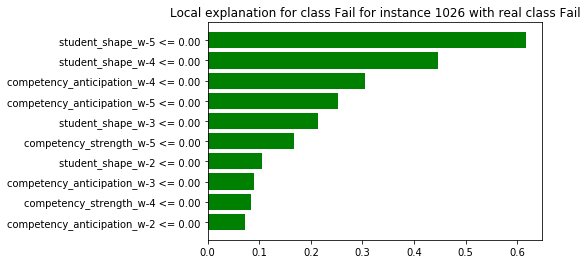

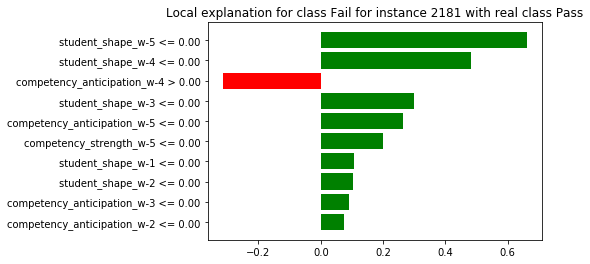

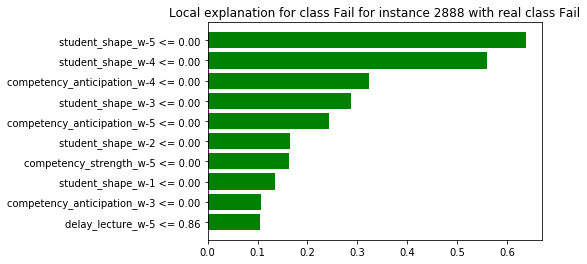

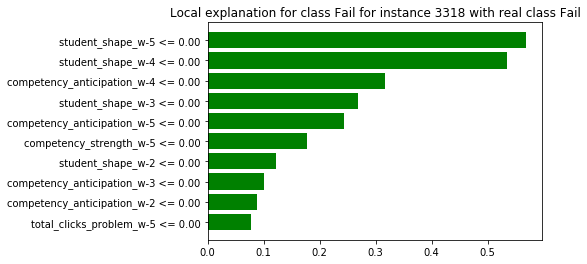

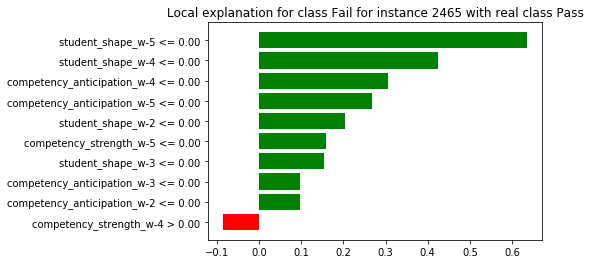

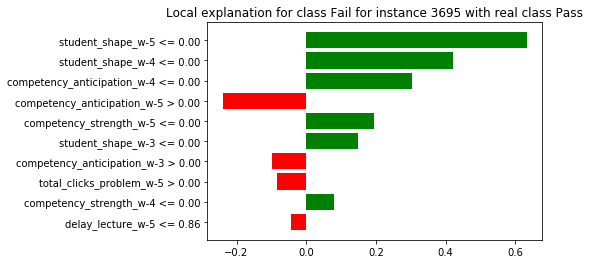

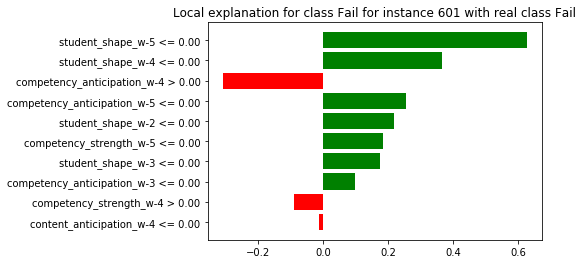

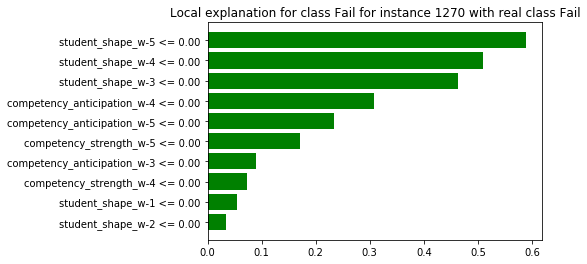

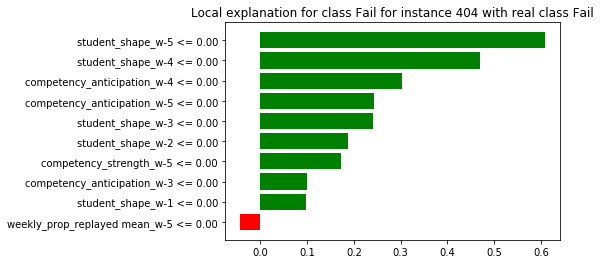

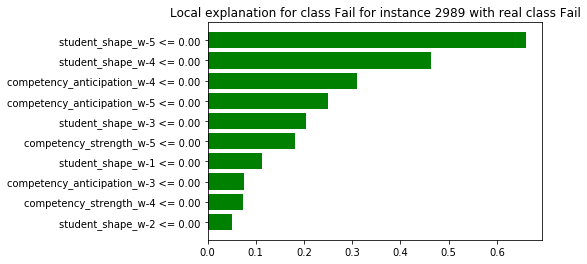

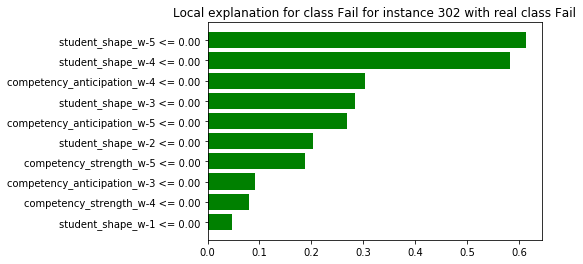

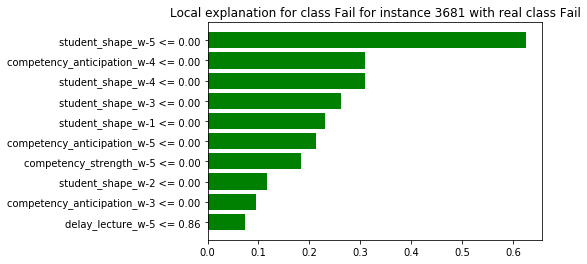

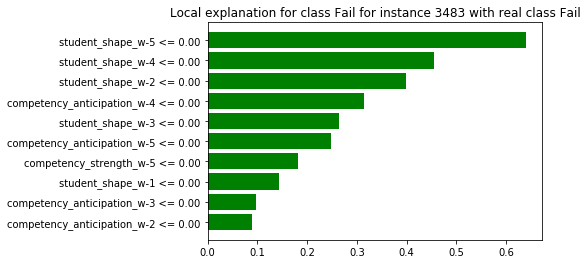

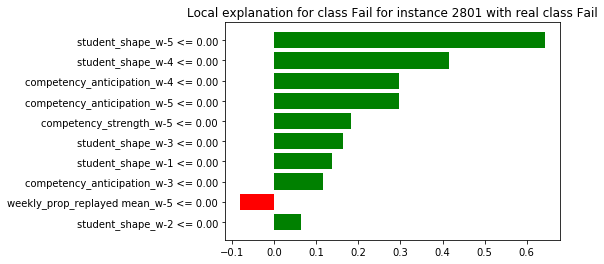

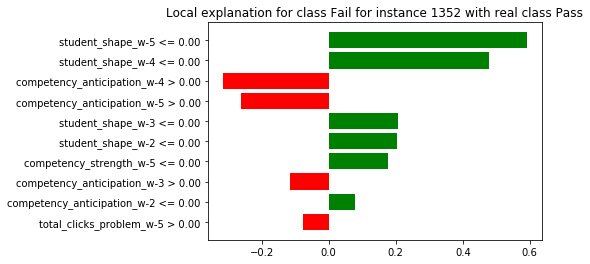

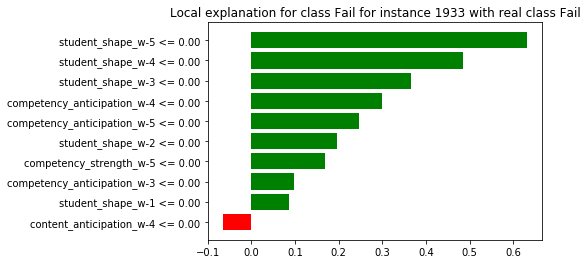

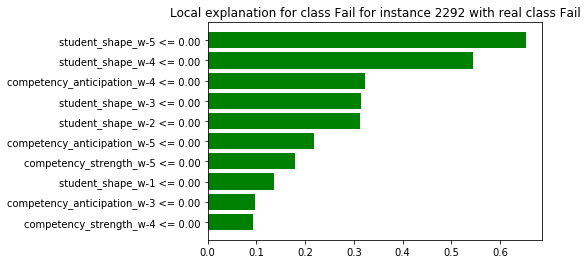

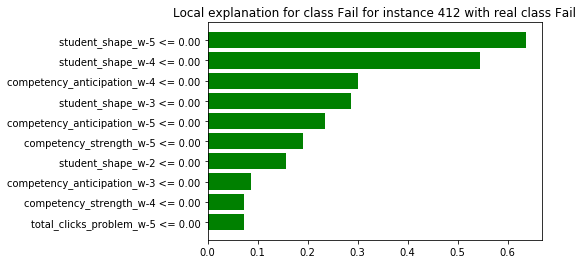

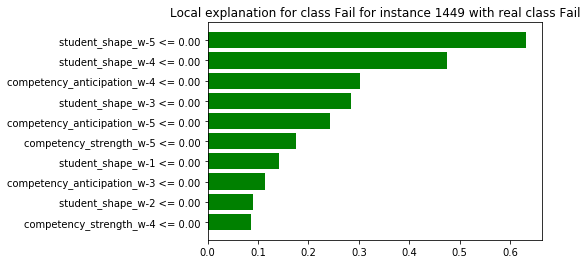

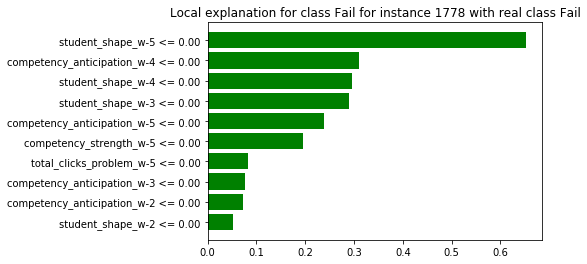

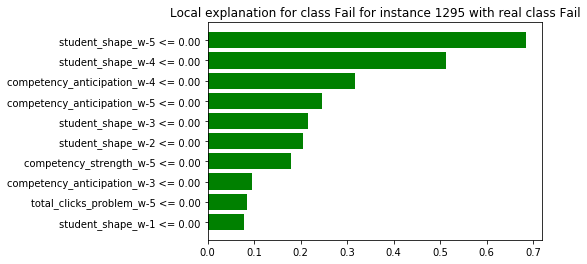

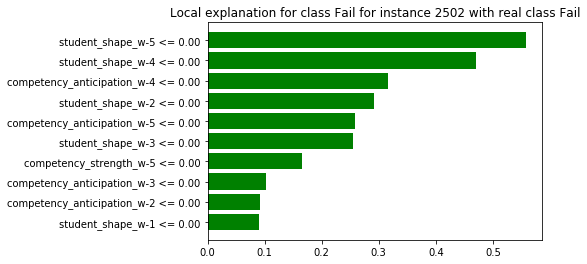

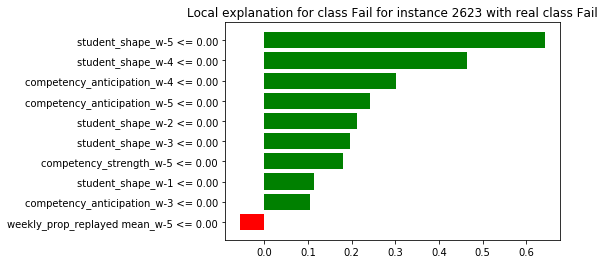

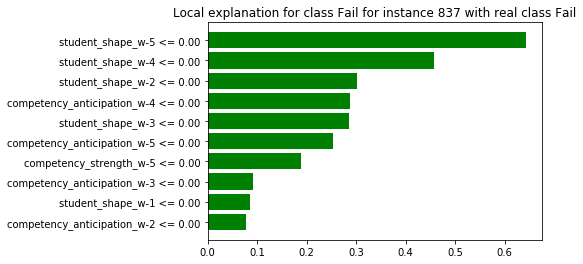

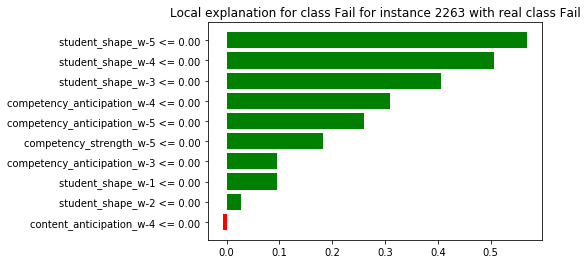

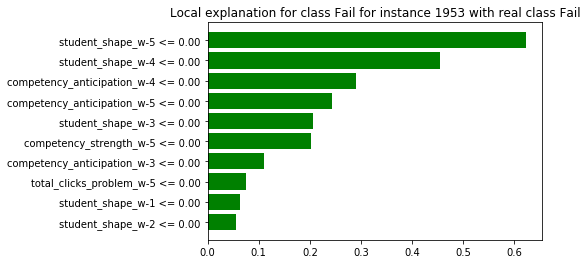

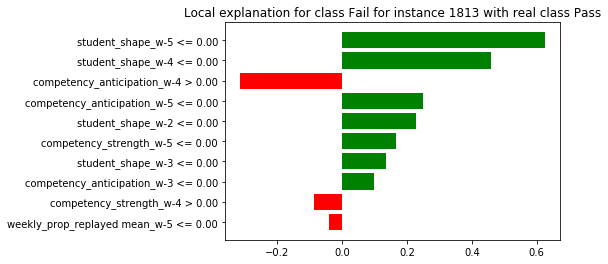

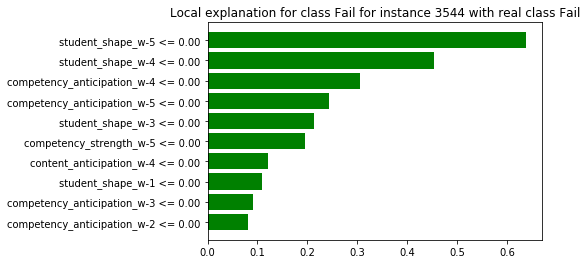

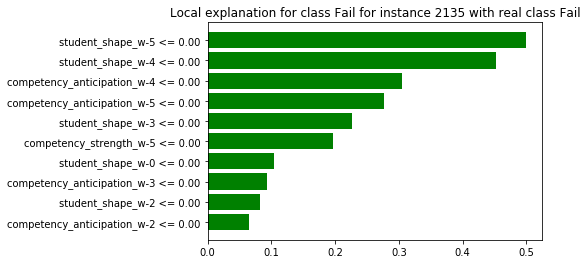

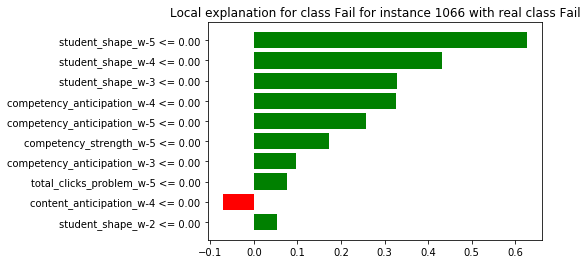

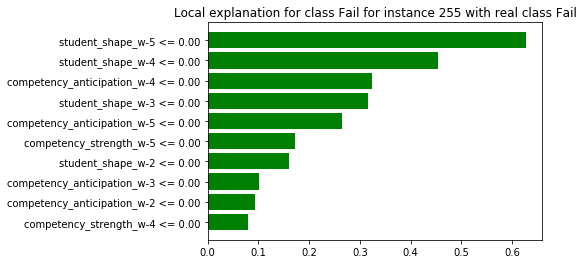

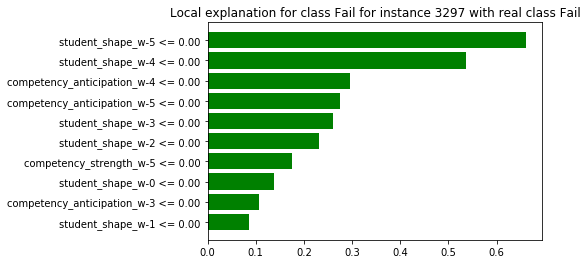

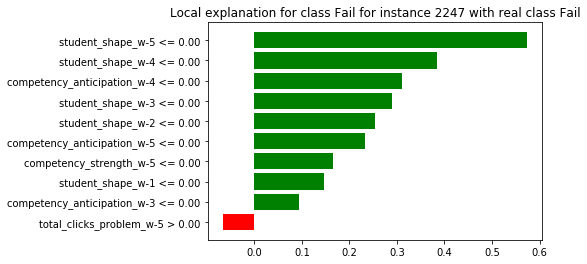

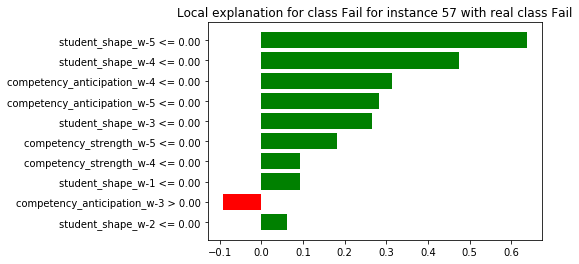

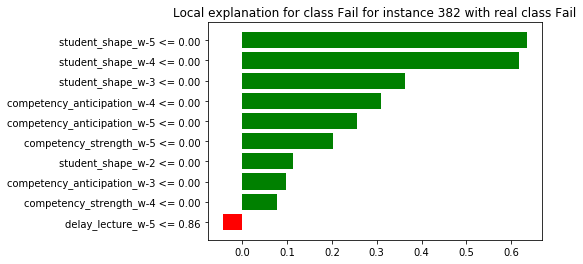

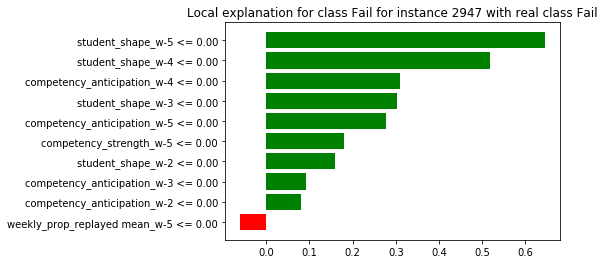

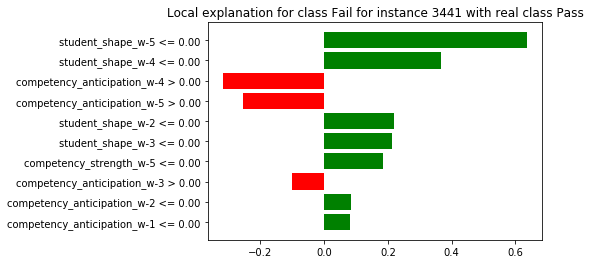

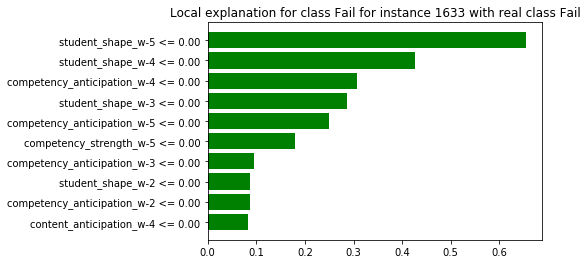

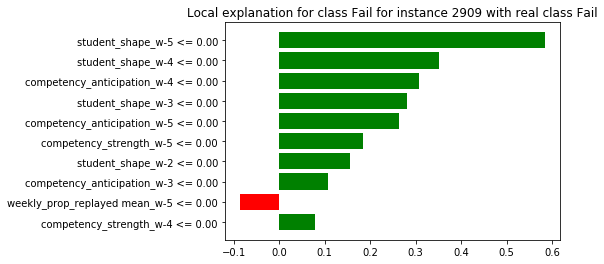

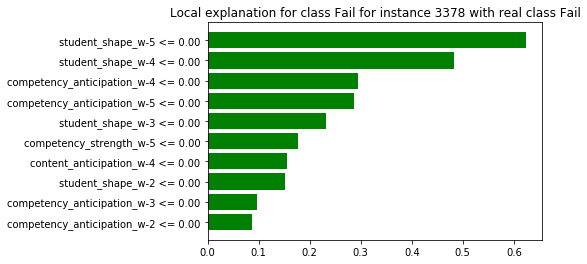

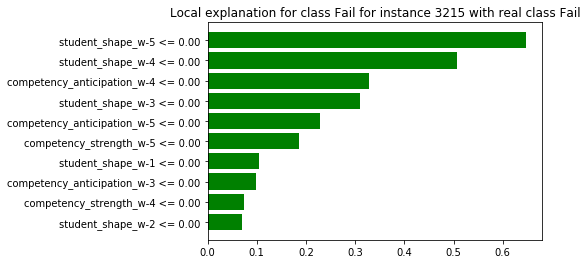

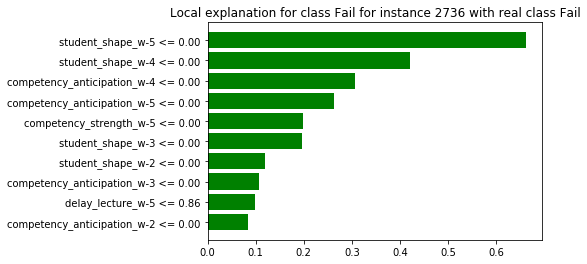

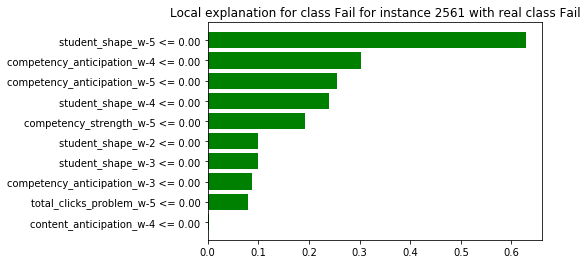

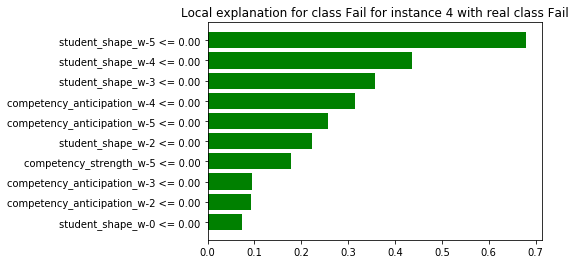

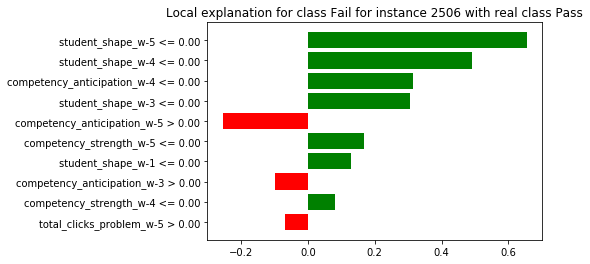

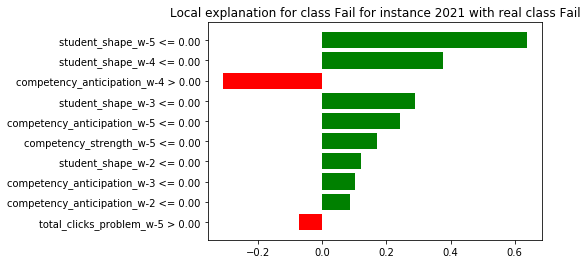

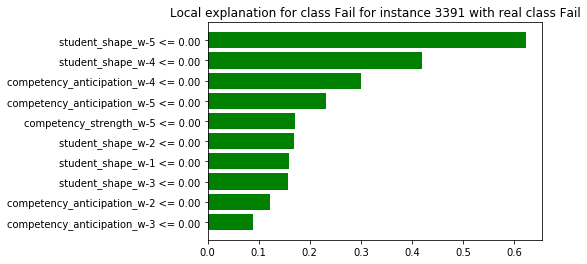

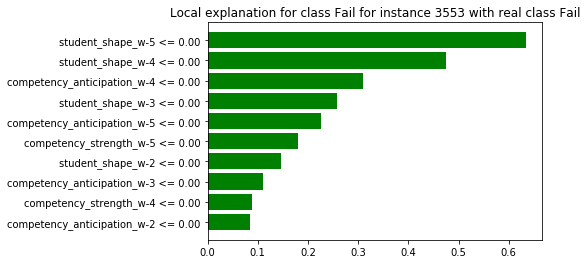

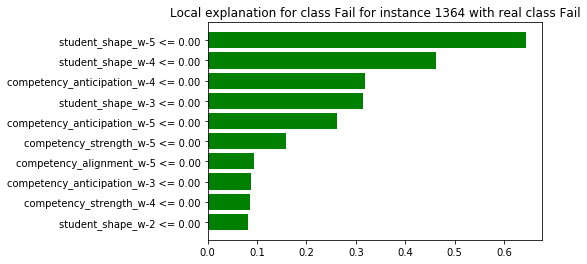

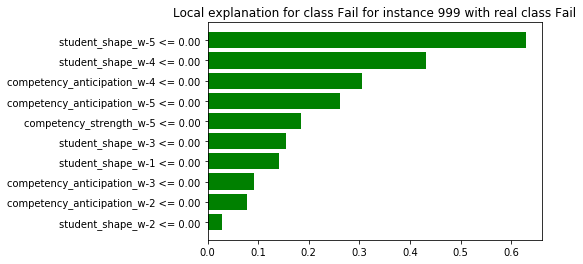

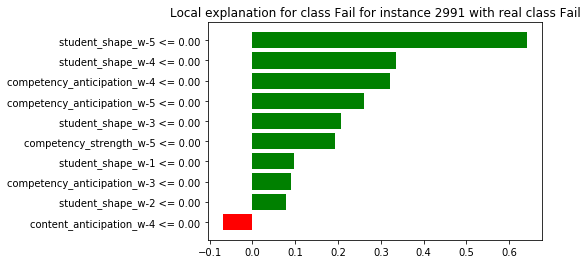

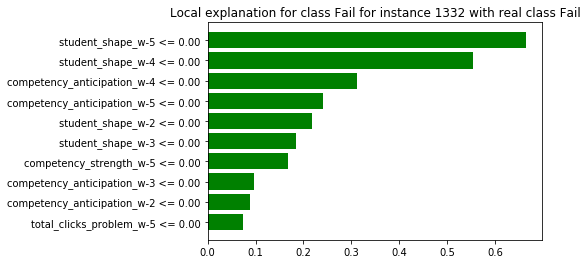

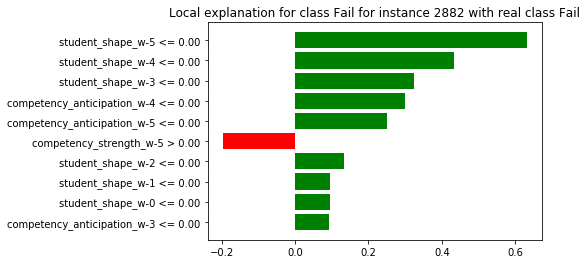

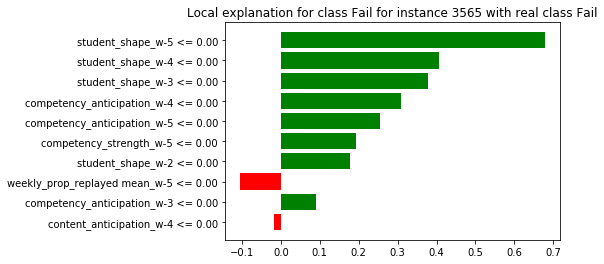

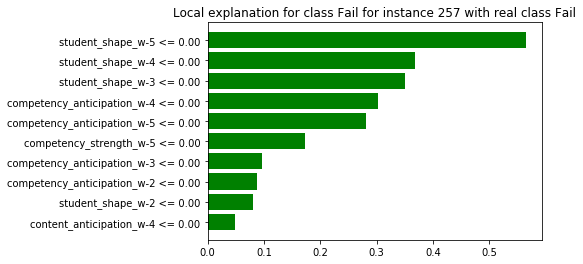

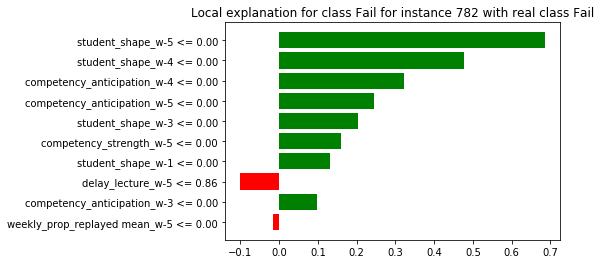

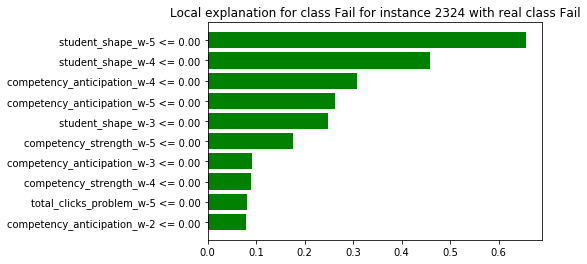

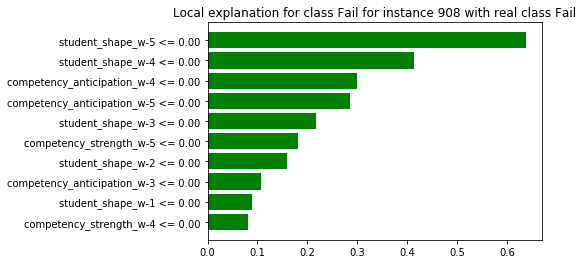

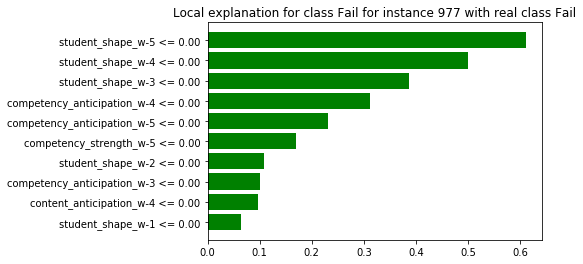

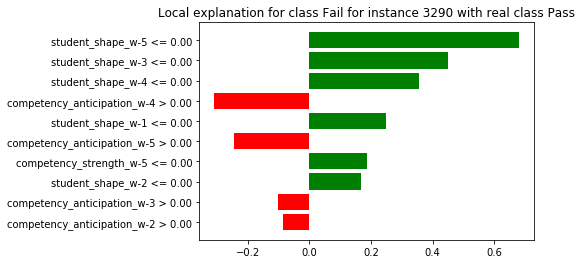

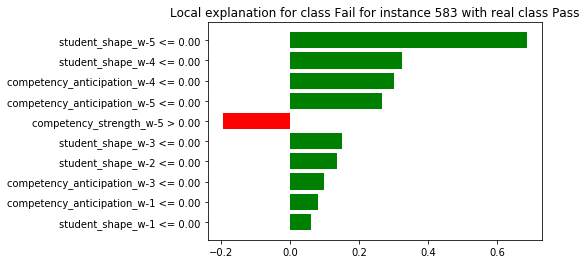

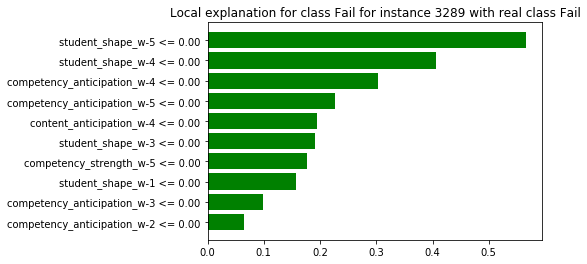

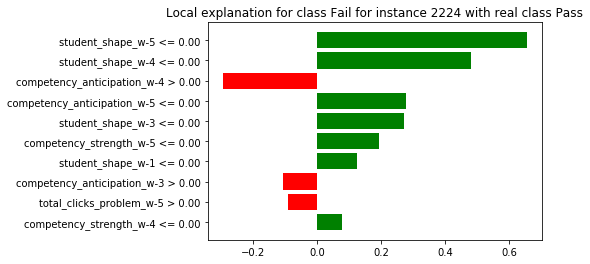

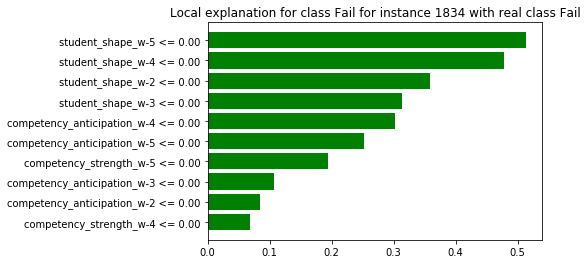

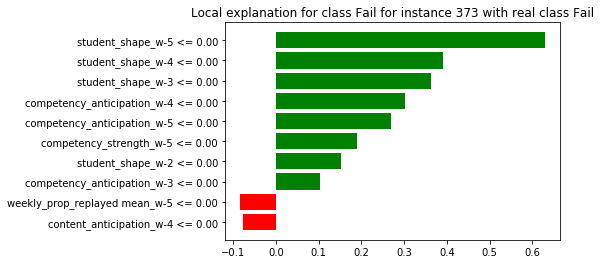

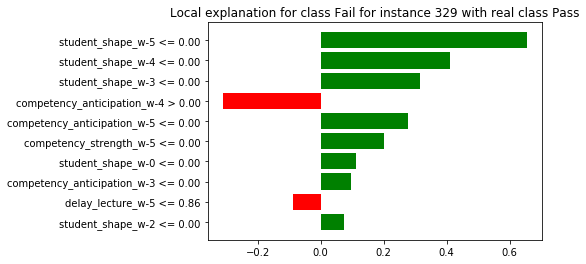

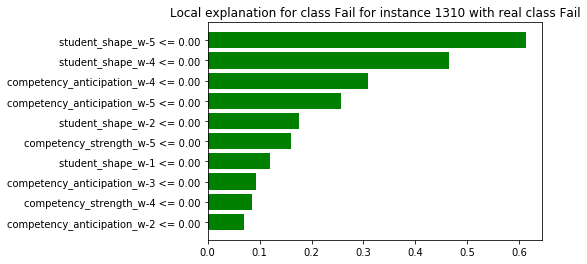

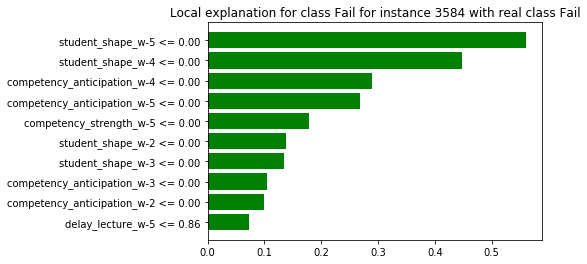

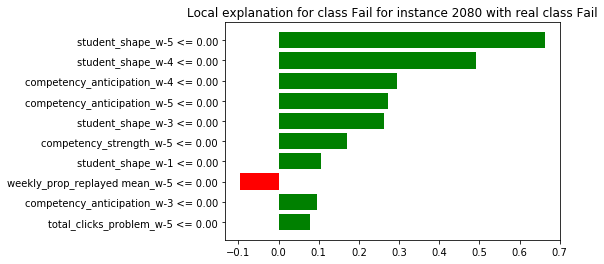

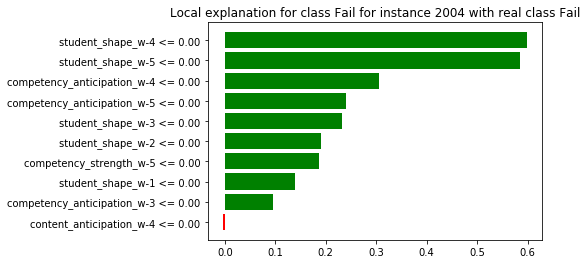

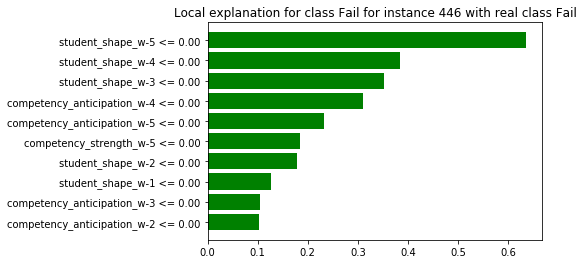

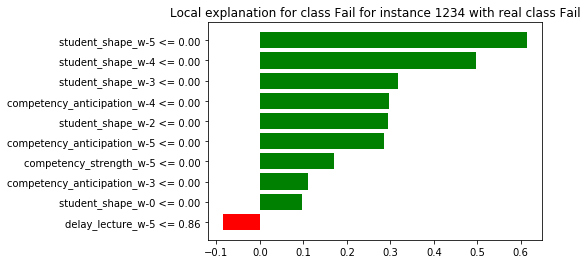

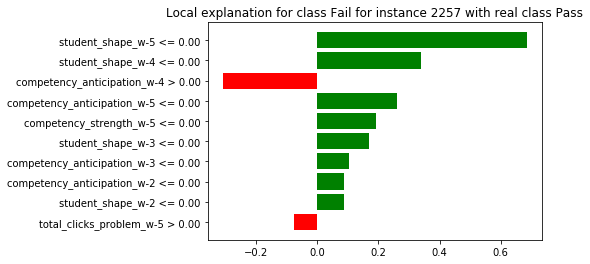

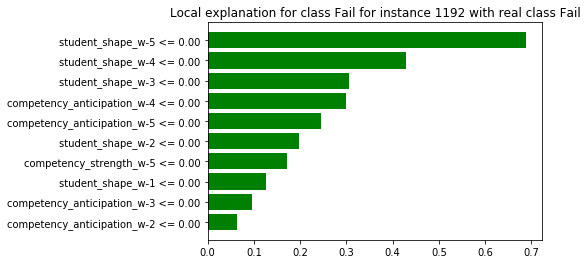

In [7]:
pyplot_all(explainers_0, instances_0, real_labels_0)

In [8]:
df_0 = DataFrame_all(explainers_0, instances_0, real_labels_0)

In [9]:
df_0.to_csv('../results/lime/spectral_clustering/lime_cluster_0.csv')

In [27]:
# df_0 = pd.read_csv('../results/lime/spectral_clustering/lime_cluster_0.csv', index_col=0)

In [28]:
# instances_0 = df_0['exp number'].tolist()

In [10]:
df_0

exp number real value  student_shape_w-5 <= 0.00  \
0         3458       Fail                   0.609292   
1         1577       Fail                   0.679945   
2         3104       Fail                   0.544401   
3         3646       Fail                   0.635133   
4         1722       Fail                   0.636740   
..         ...        ...                        ...   
95        2004       Fail                   0.584876   
96         446       Fail                   0.636957   
97        1234       Fail                   0.614743   
98        2257       Pass                   0.686104   
99        1192       Fail                   0.689052   

    student_shape_w-4 <= 0.00  competency_anticipation_w-4 <= 0.00  \
0                    0.459459                             0.304816   
1                    0.410484                             0.315218   
2                    0.529292                             0.312401   
3                    0.391404                             0.315092   
4                    0.545965                             0.305486   
..                        ...                                  ...   
95                   0.599079                             0.305547   
96                   0.383578                             0.310909   
97                   0.495971                             0.296979   
98                   0.340659                                  NaN   
99                   0.428290                             0.299003   

    competency_anticipation_w-5 <= 0.00  competency_strength_w-5 <= 0.00  \
0                              0.270098                         0.196172   
1                              0.251754                         0.179376   
2                              0.257853                         0.172142   
3                              0.229800                         0.198918   
4                              0.212584                         0.192556   
..                                  ...                              ...   
95                             0.240448                         0.187229   
96                             0.233171                         0.185203   
97                             0.285774                         0.170843   
98                             0.260682                         0.191309   
99                             0.245049                         0.171467   

    student_shape_w-1 <= 0.00  student_shape_w-2 <= 0.00  \
0                    0.171514                   0.131444   
1                    0.114162                   0.145489   
2                         NaN                   0.086128   
3                         NaN                   0.065511   
4                    0.129479                   0.243079   
..                        ...                        ...   
95                   0.139715                   0.190934   
96                   0.126876                   0.179586   
97                        NaN                   0.294683   
98                        NaN                   0.088264   
99                   0.125512                   0.198032   

    competency_anticipation_w-3 <= 0.00  ...  \
0                              0.108120  ...   
1                              0.105777  ...   
2                              0.090858  ...   
3                              0.099431  ...   
4                              0.090645  ...   
..                                  ...  ...   
95                             0.094939  ...   
96                             0.103764  ...   
97                             0.110725  ...   
98                             0.103883  ...   
99                             0.096285  ...   

    competency_anticipation_w-4 > 0.00  student_shape_w-0 <= 0.00  \
0                                  NaN                        NaN   
1                                  NaN                        NaN   
2                                  NaN                        NaN   
3  

In [11]:
def preprocess_features(df):
    top_features = df.columns
    top_features = top_features[2::]
    top_features_type = np.array([s.split('_w-')[0] for s in top_features])
    top_features_week = np.array(['Week_'+s[s.find('_w-')+3::].split(' ')[0] for s in top_features])
    count = (~(df.iloc[:,2::].isnull())).values.sum(axis=0)
    top_features_type_unique = list({ k for k in top_features_type })
    count_feature_type = [count[top_features_type==x].sum()/np.sum(count) for x in top_features_type_unique]
    top_features_week_unique = sorted(list({ k for k in top_features_week }))
    count_feature_week = [count[top_features_week==x].sum()/np.sum(count) for x in top_features_week_unique]
    return count, top_features_type, top_features_week, top_features_type_unique, count_feature_type, top_features_week_unique, count_feature_week

In [12]:
count, top_features_type, top_features_week, top_features_type_unique, count_feature_type, top_features_week_unique, count_feature_week = preprocess_features(df_0)

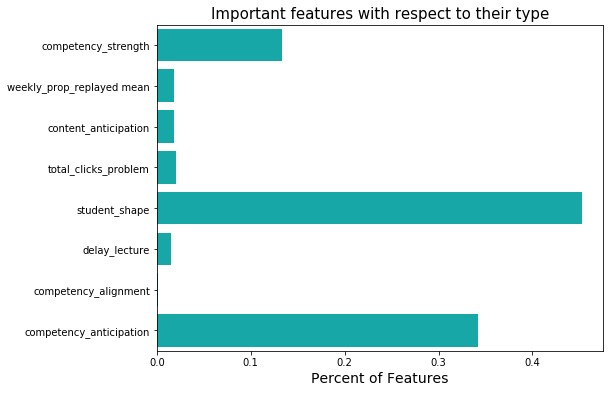

In [13]:
ind = np.argsort(count_feature_type)[::-1]
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.barplot(x=count_feature_type, y= top_features_type_unique, orient = 'h', color='c', ax =ax)
g.set_title( 'Important features with respect to their type', fontsize=15)
g.set_xlabel("Percent of Features", fontsize=14)
plt.show()

In [107]:
# pass_df = df_0[df_0['real value'] == 'Pass']
# fail_df = df_0[df_0['real value'] == 'Fail']
# _, _, _, top_features_type_unique_pass, count_feature_type_pass, _, _ = preprocess_features(pass_df)
# _, _, _, top_features_type_unique_fail, count_feature_type_fail, _, _ = preprocess_features(fail_df)

In [108]:
# ind = np.argsort(count_feature_type)[::-1]
# plt.figure(figsize=(8, 6))
# plt.barh(top_features_type_unique_pass, count_feature_type_pass, color='tomato', label='Pass')
# plt.barh(top_features_type_unique_fail, count_feature_type_fail, color='c', left=count_feature_type_pass, label='Fail')
# plt.title( 'Important features with respect to their type', fontsize=15)
# plt.xlabel("Percent of Features", fontsize=14)
# plt.legend()
# plt.show()

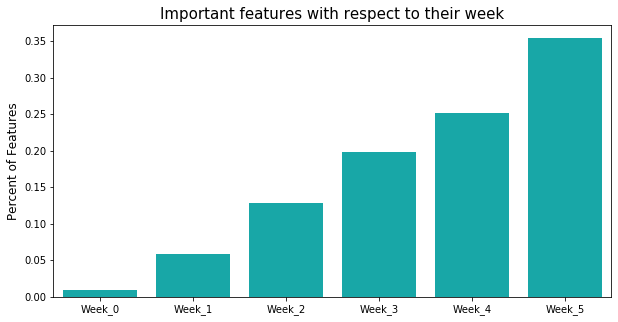

In [14]:
ind = np.argsort(count_feature_week)[::-1]
fig, ax = plt.subplots(figsize=(10, 5),facecolor='white')
g = sns.barplot(x=top_features_week_unique, y=count_feature_week, color='c',ax =ax)
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_title( 'Important features with respect to their week', fontsize=15)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Percent of Features", fontsize=12)
plt.show()

In [15]:
zero_data = np.zeros(shape=(6,len(top_features_type_unique)))
d = pd.DataFrame(zero_data, columns=top_features_type_unique)
for i,f in enumerate(top_features_type):
    d[f][int(top_features_week[i].split('_')[1])]+=count[i]

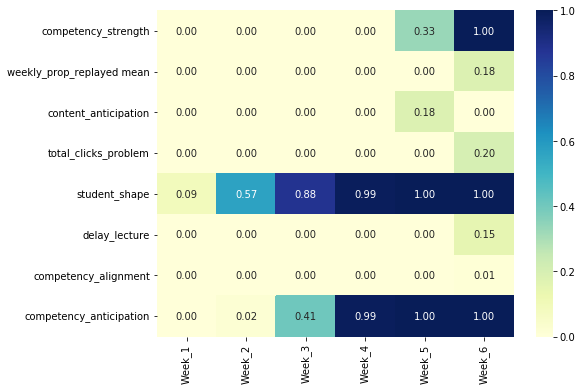

In [16]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d.values.T / len(instances_0), annot=True, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.set_xticklabels(['Week_'+str(i) for i in l],rotation=90)
g.set_yticklabels(top_features_type_unique,rotation=0)
plt.show()

## Cluster 1

In [17]:
explainers_1, instances_1, real_labels_1 = get_instance_explanations(1)

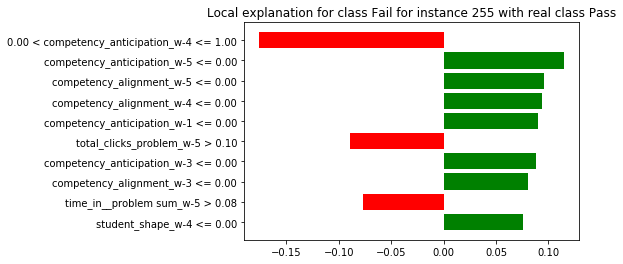

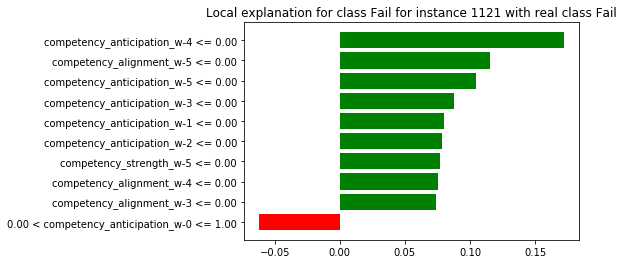

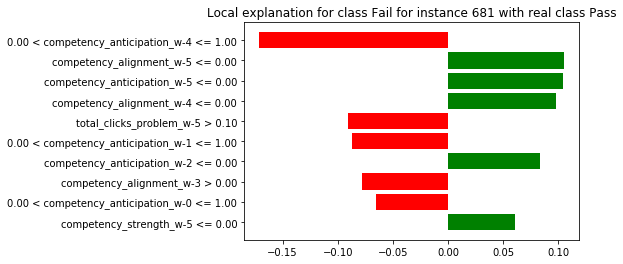

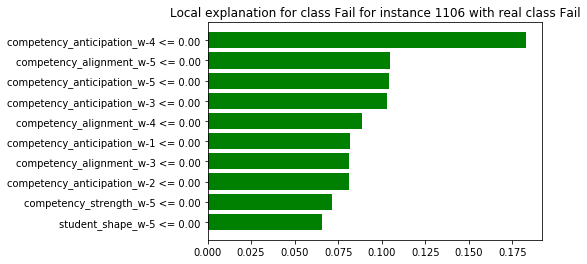

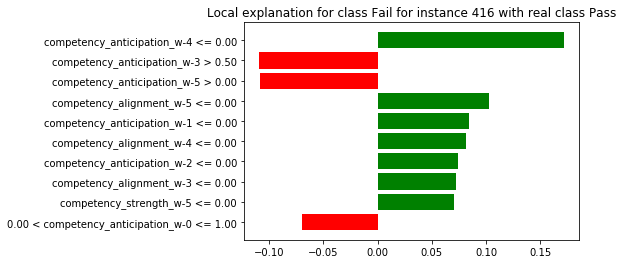

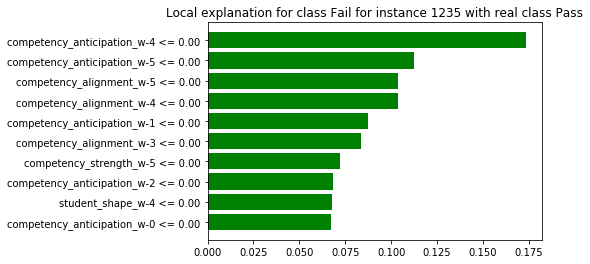

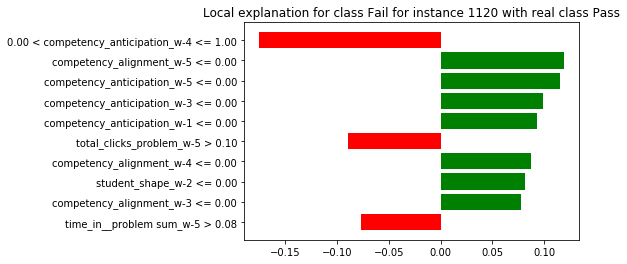

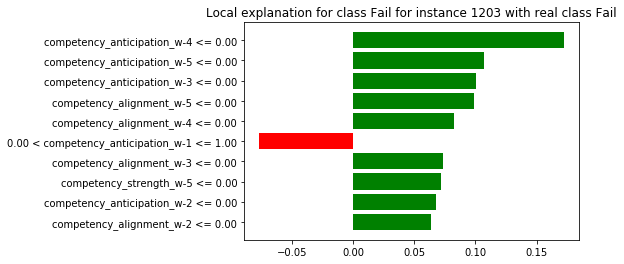

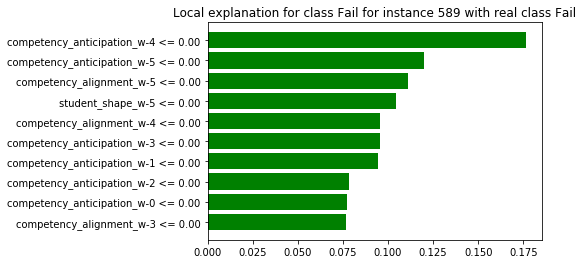

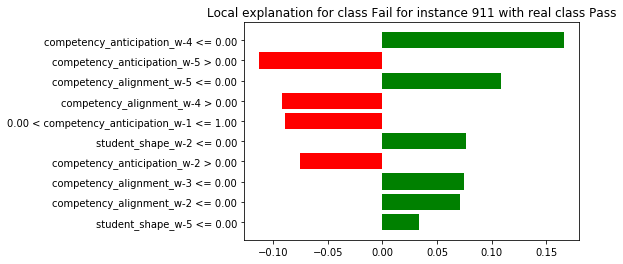

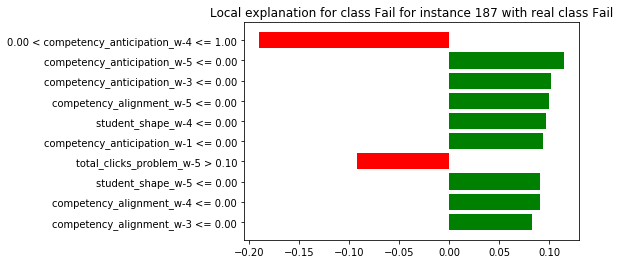

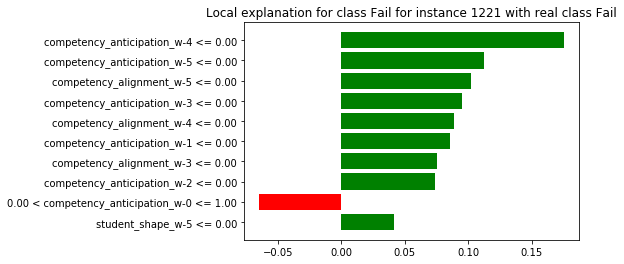

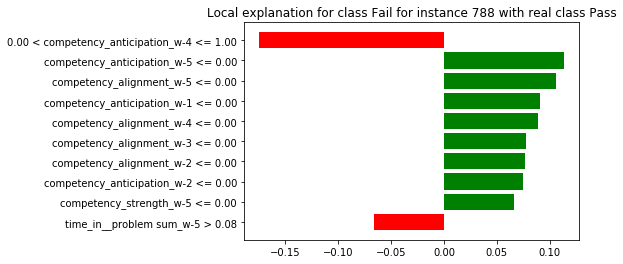

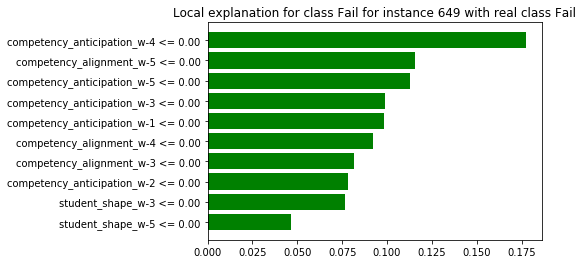

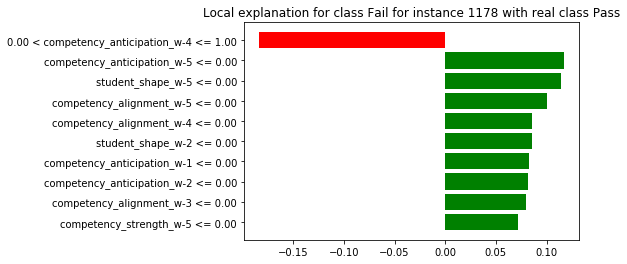

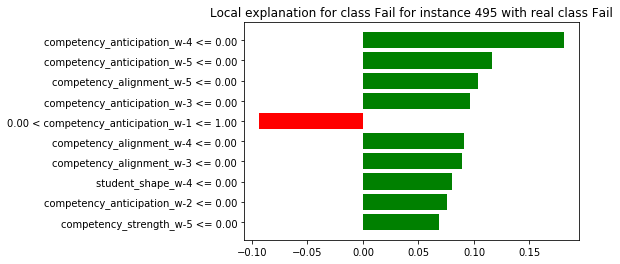

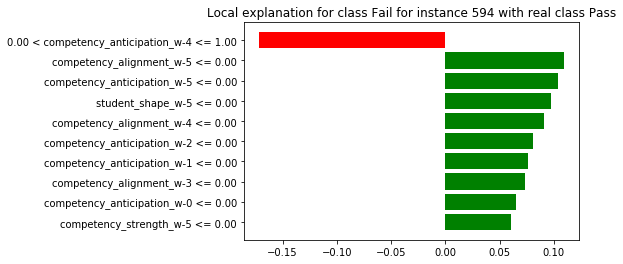

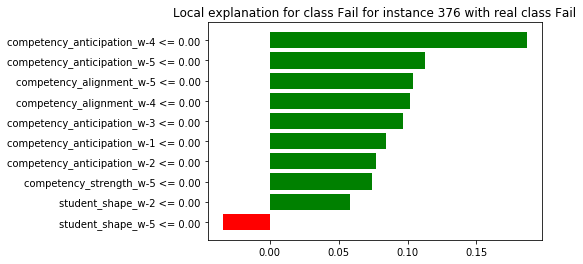

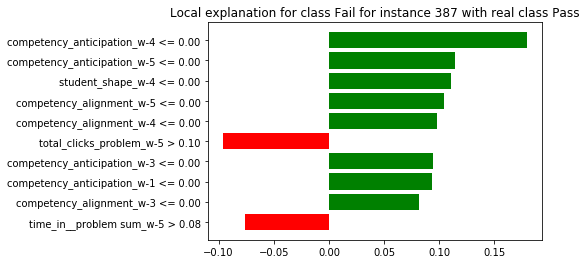

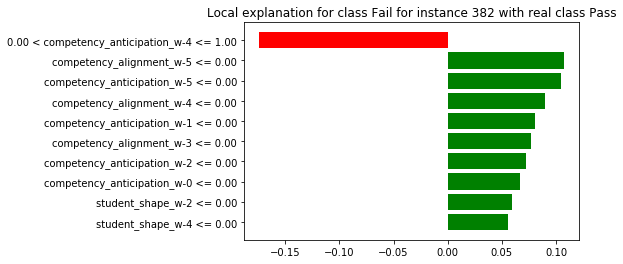

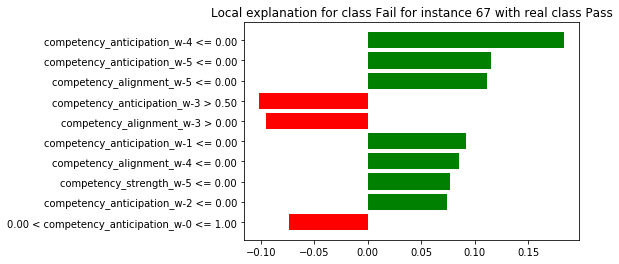

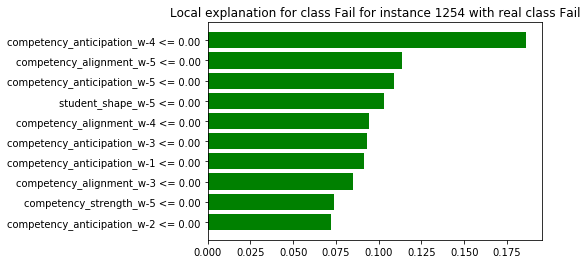

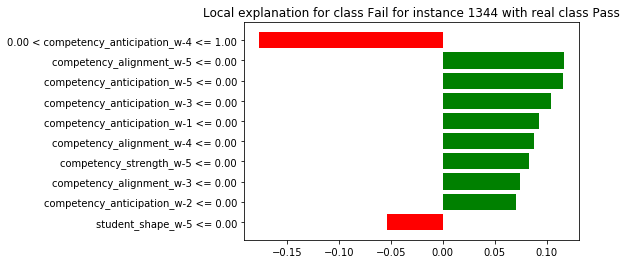

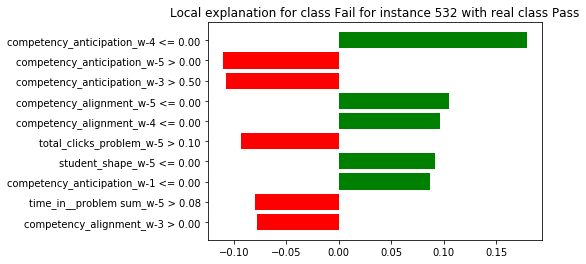

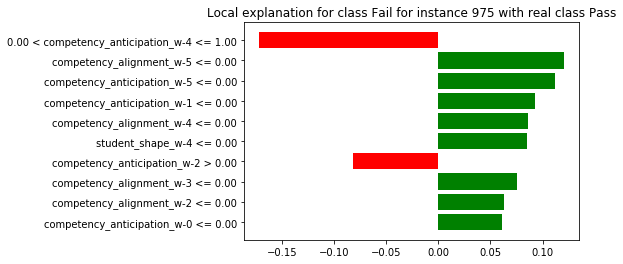

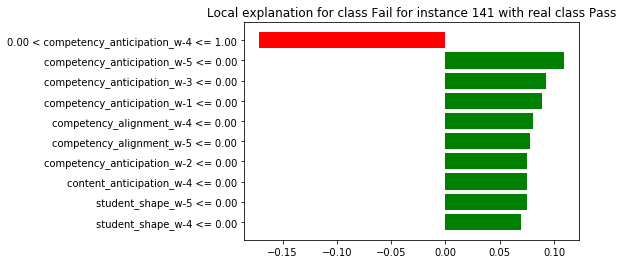

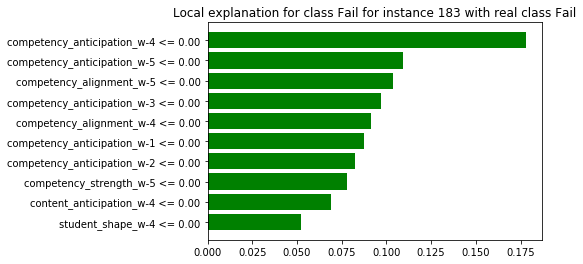

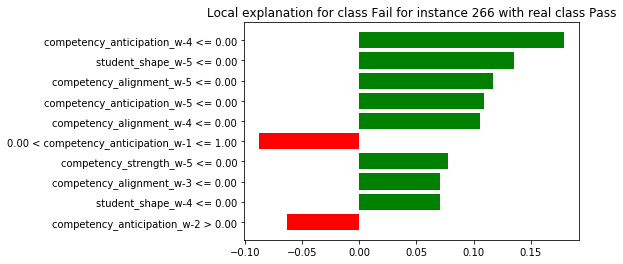

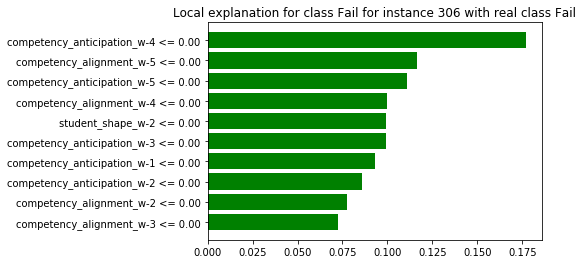

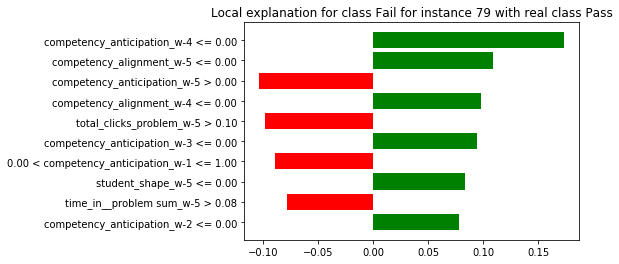

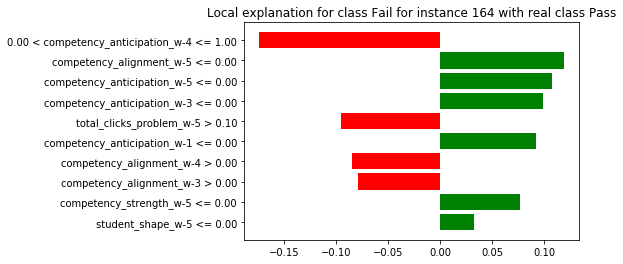

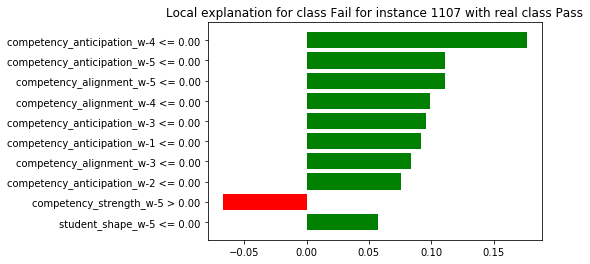

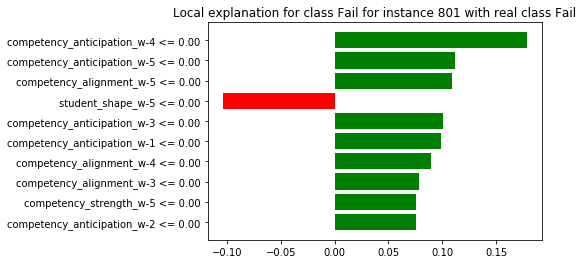

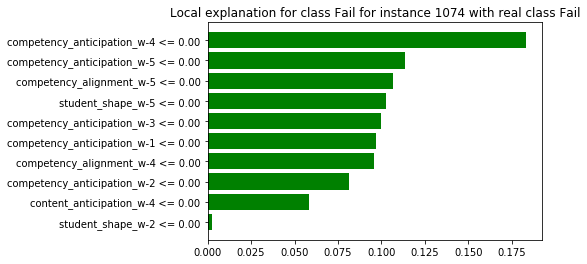

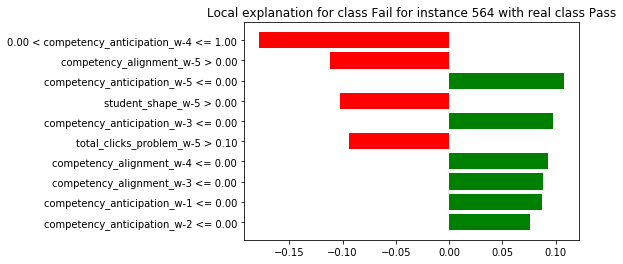

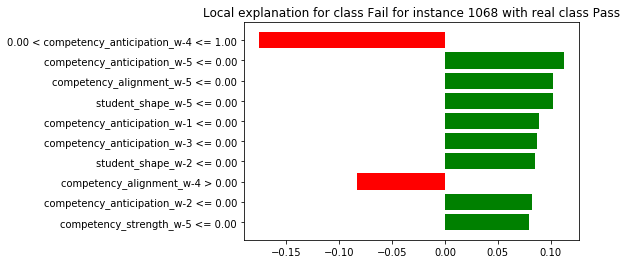

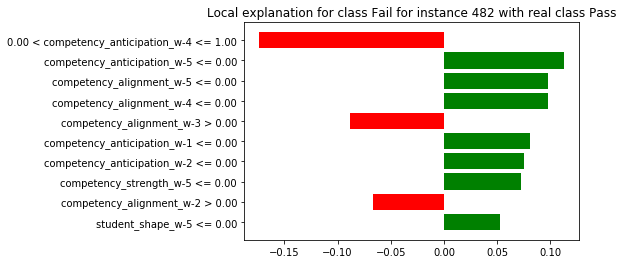

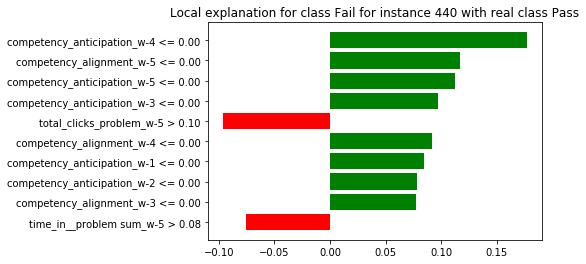

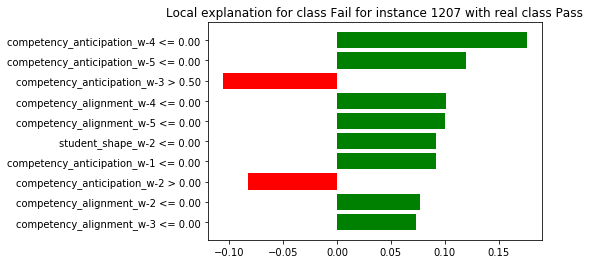

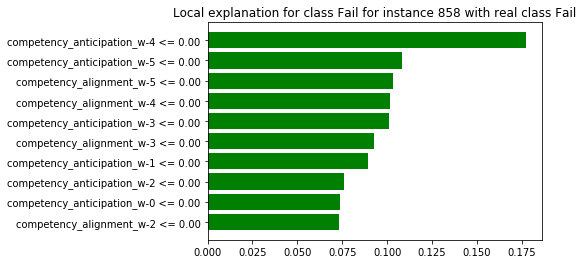

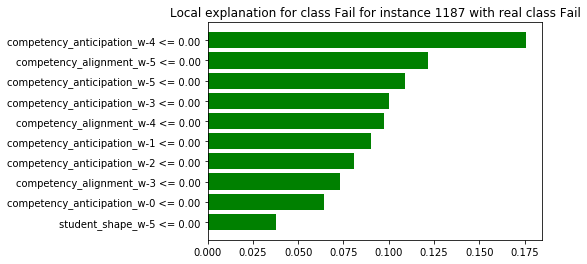

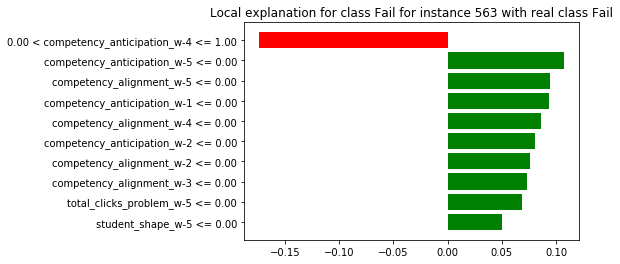

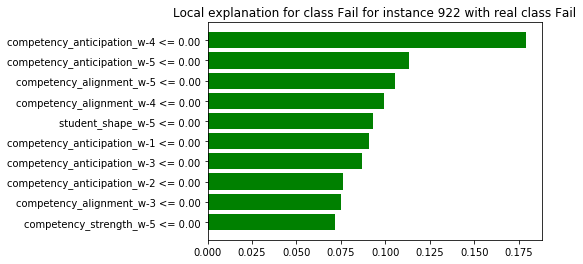

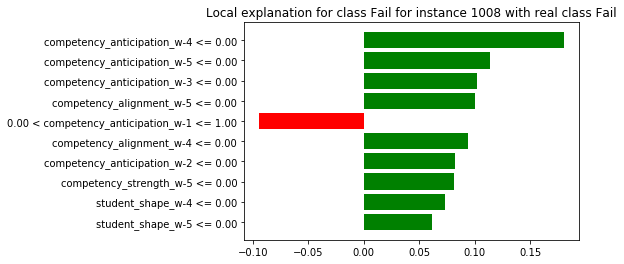

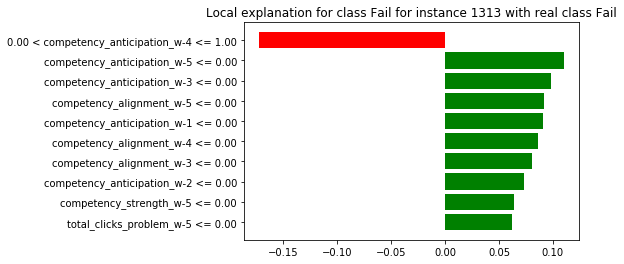

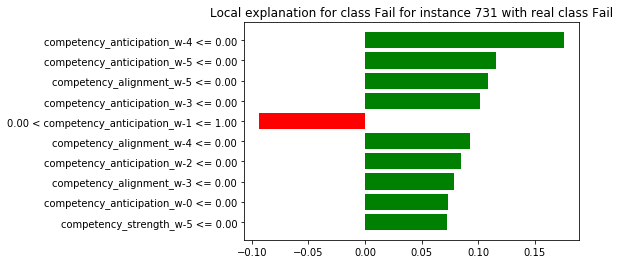

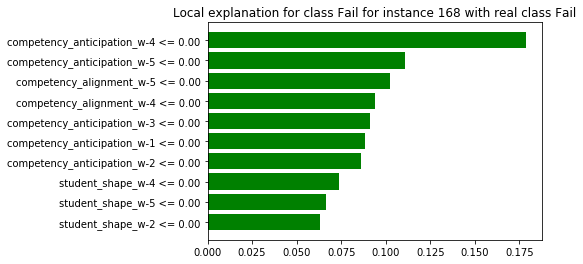

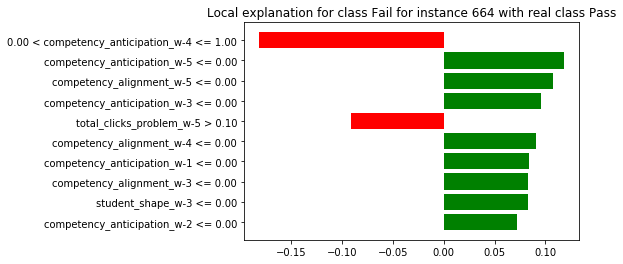

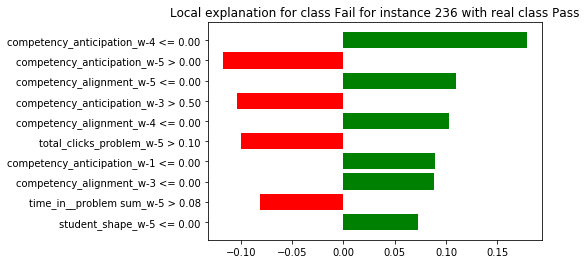

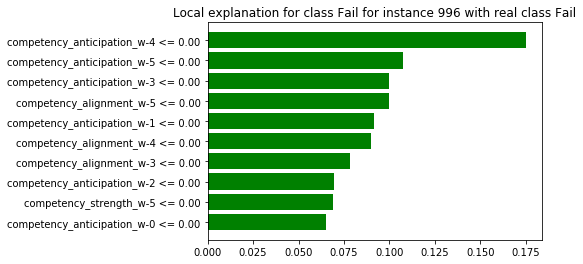

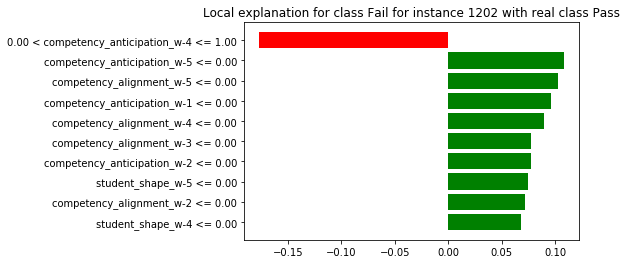

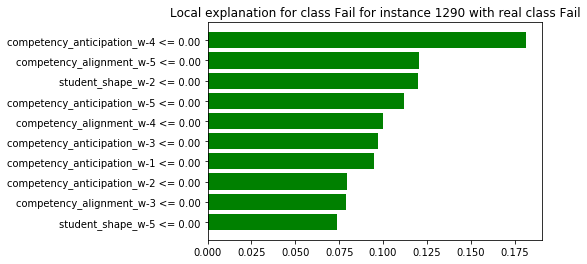

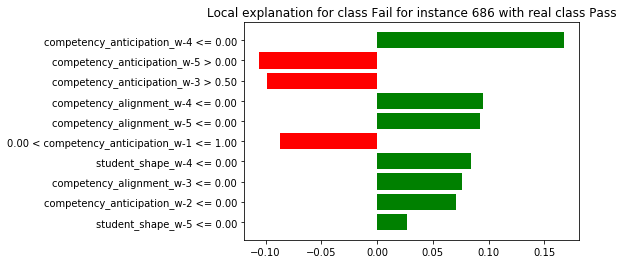

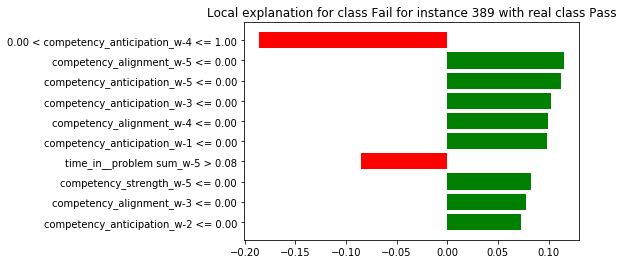

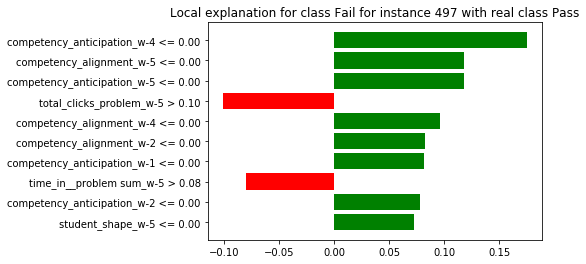

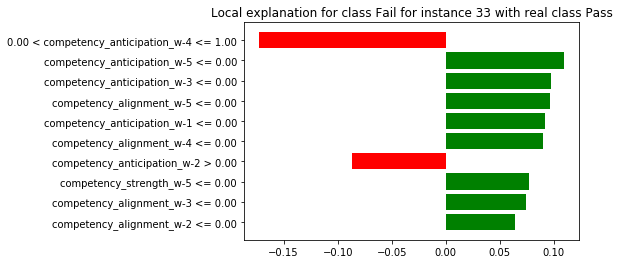

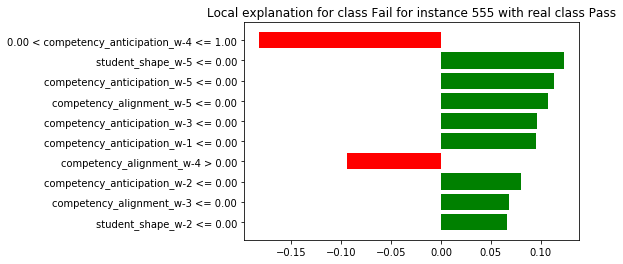

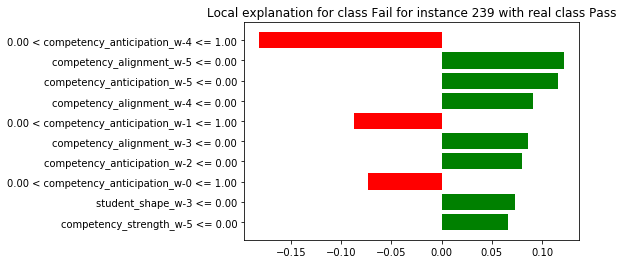

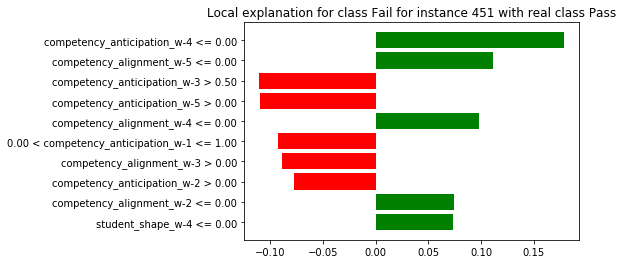

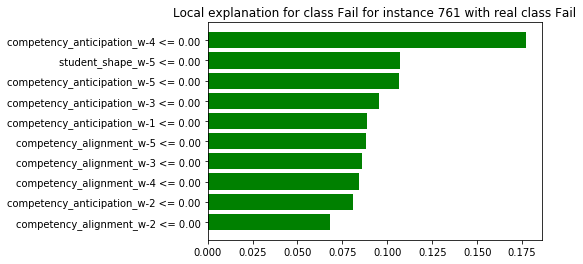

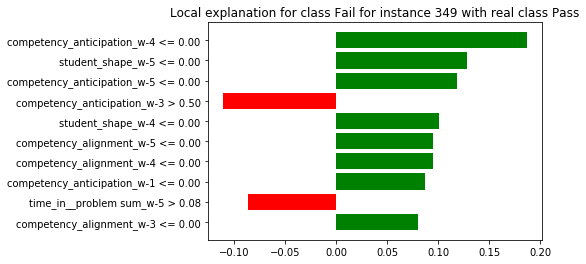

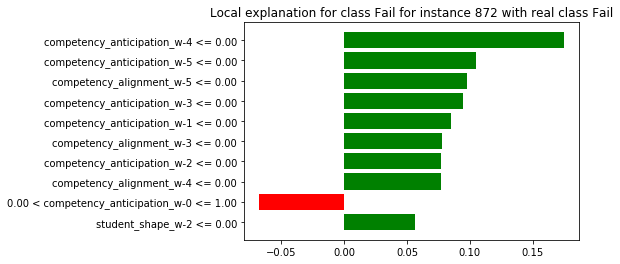

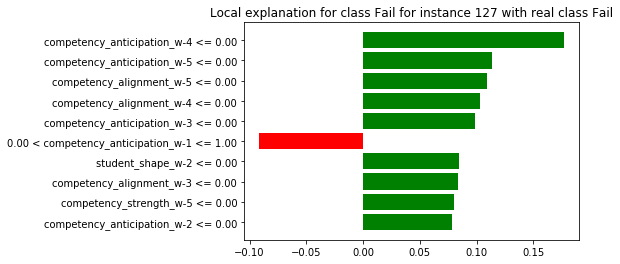

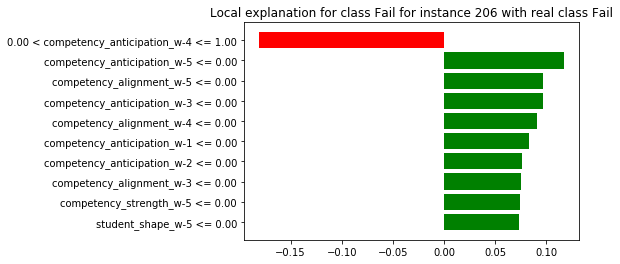

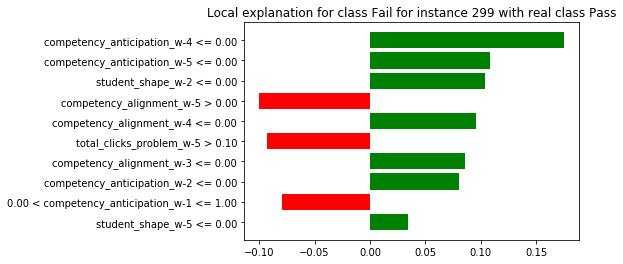

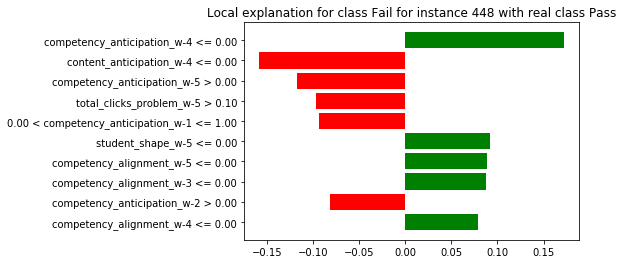

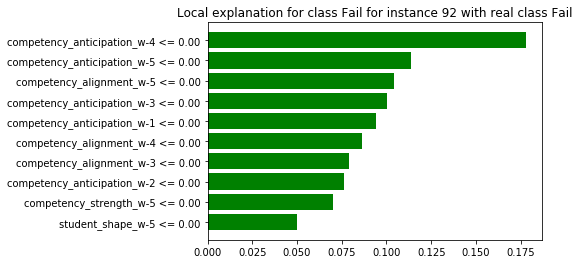

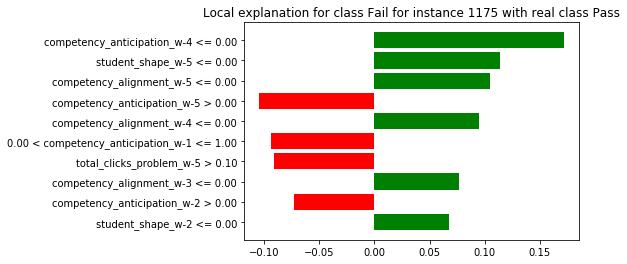

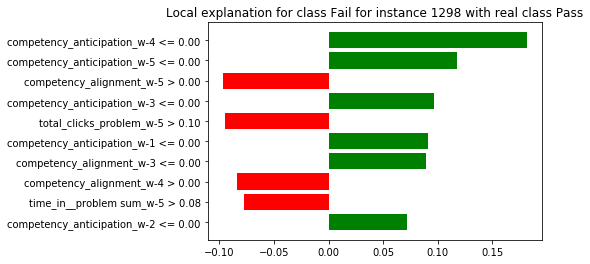

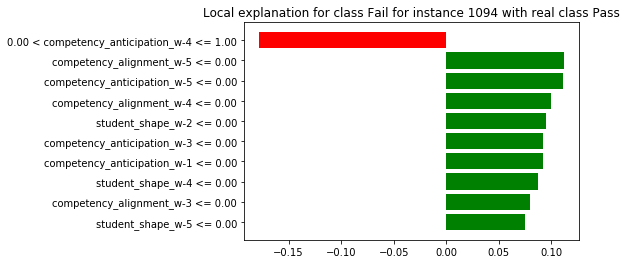

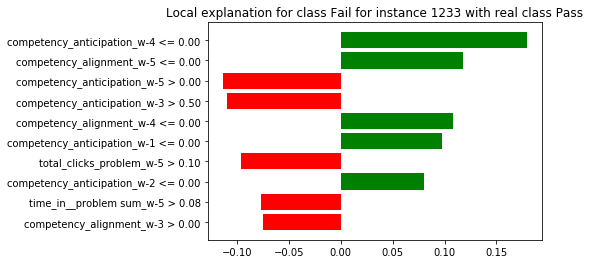

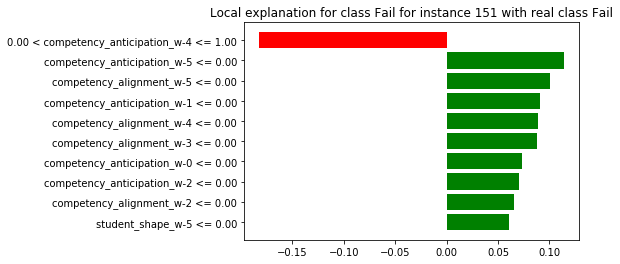

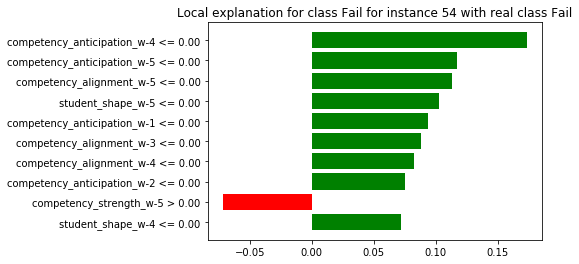

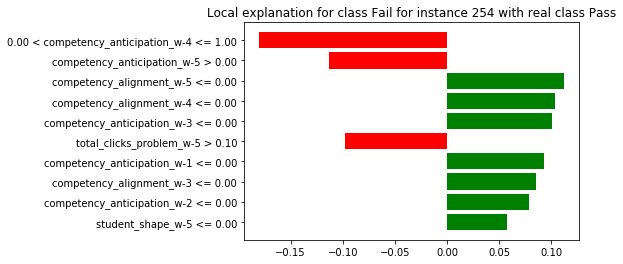

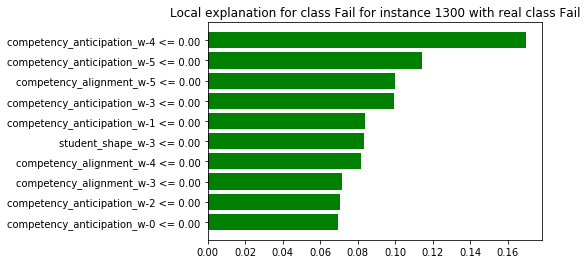

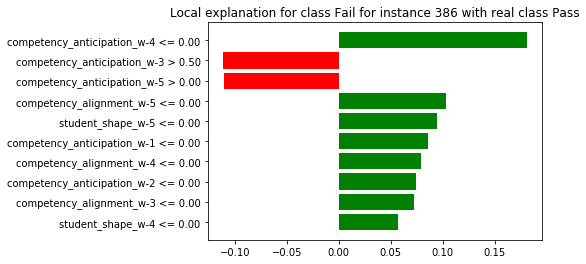

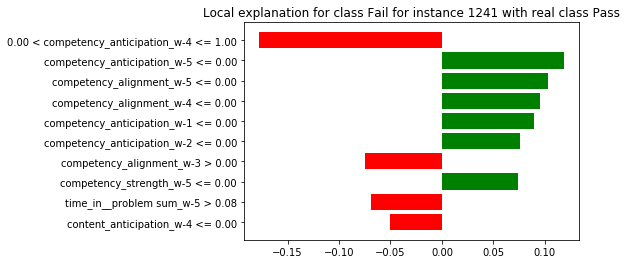

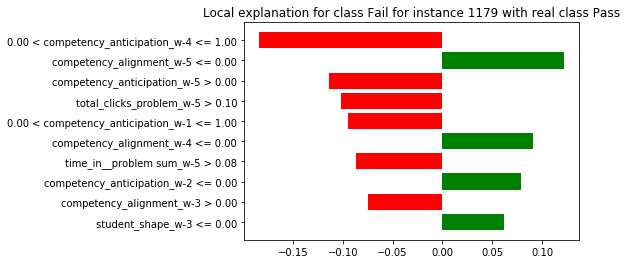

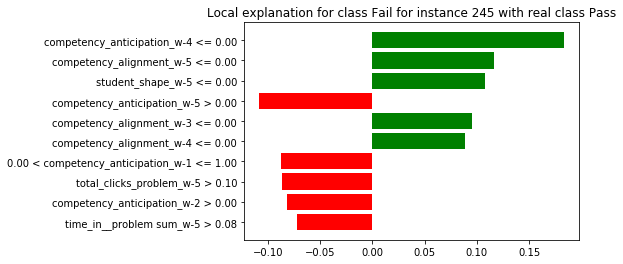

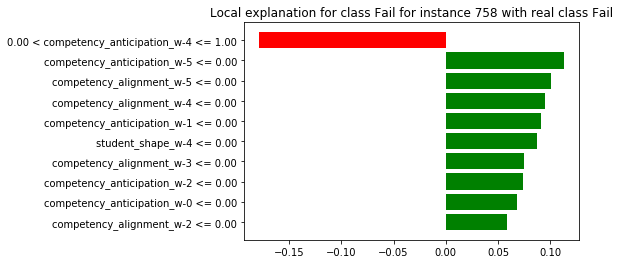

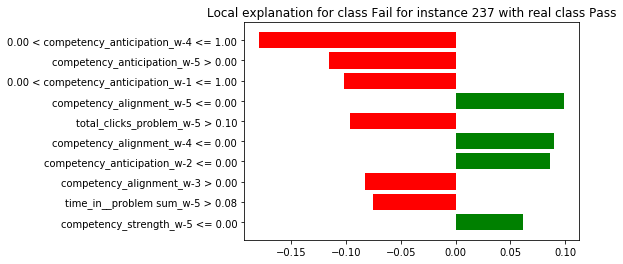

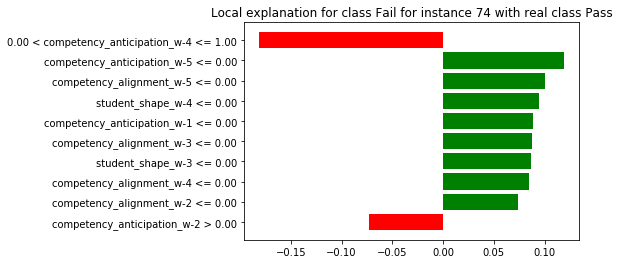

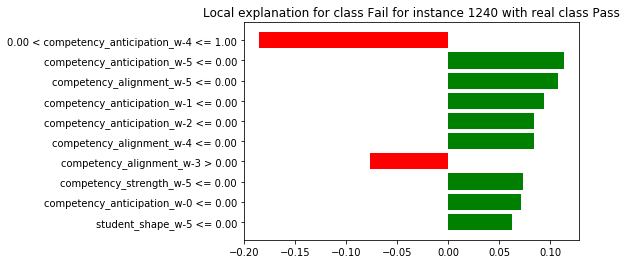

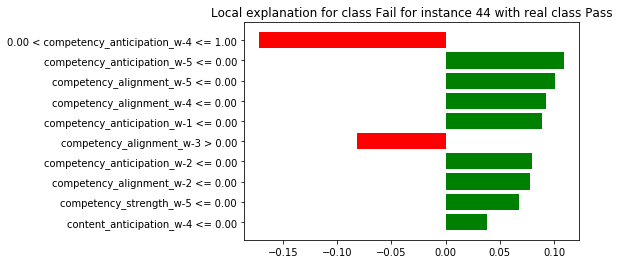

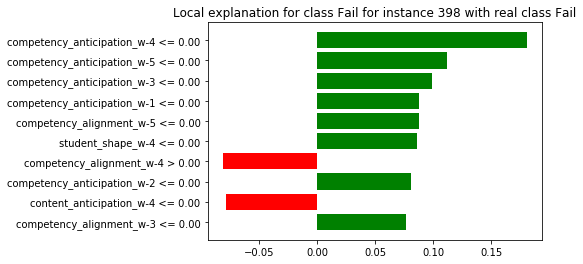

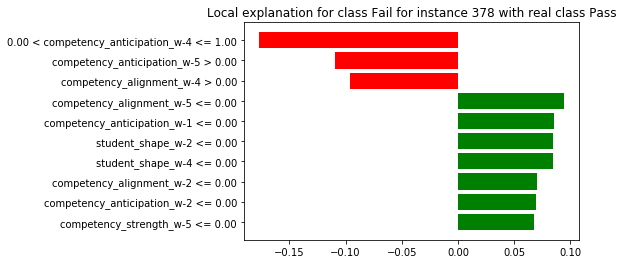

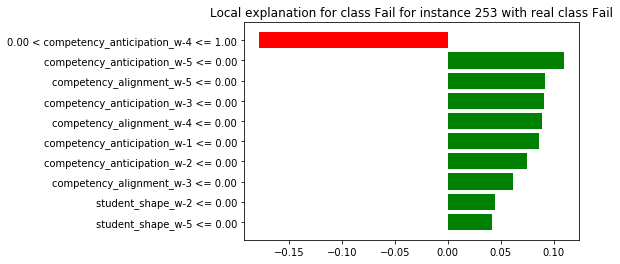

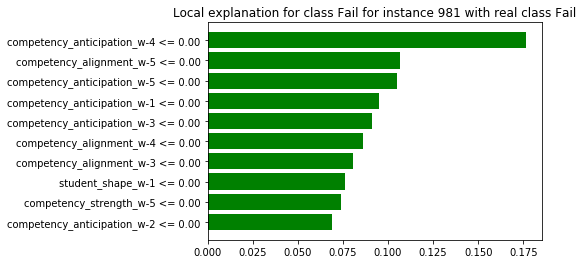

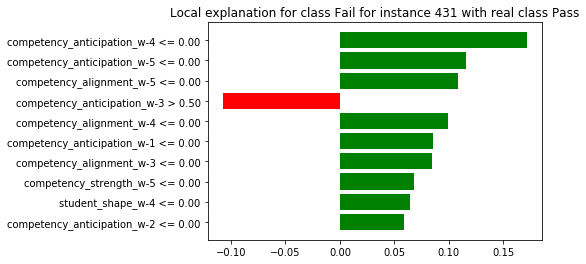

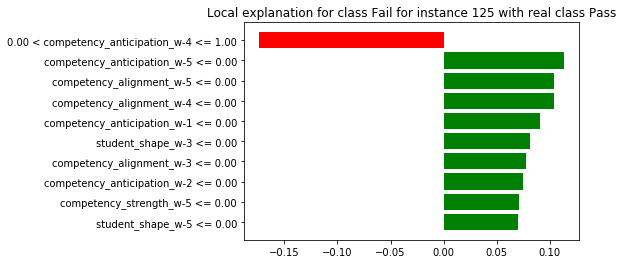

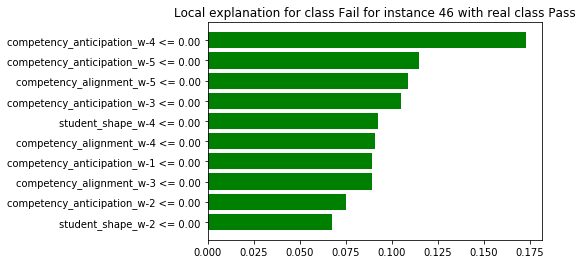

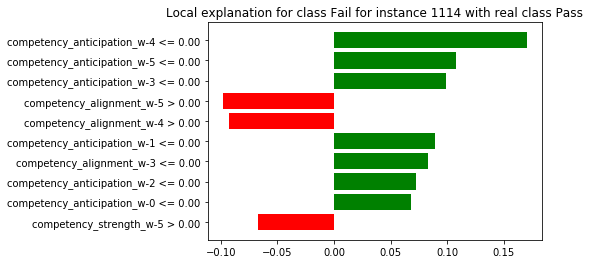

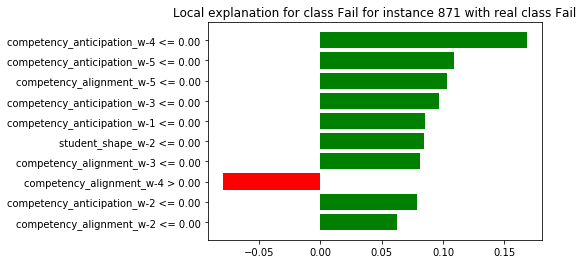

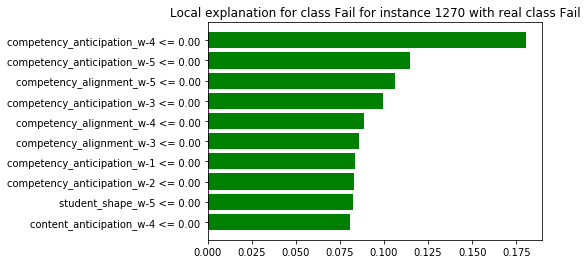

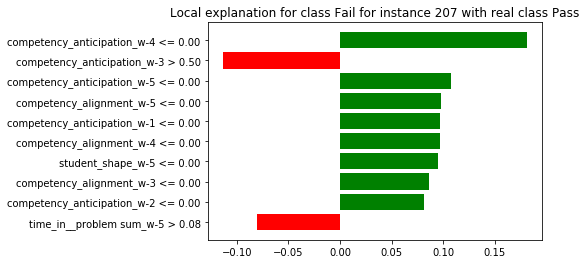

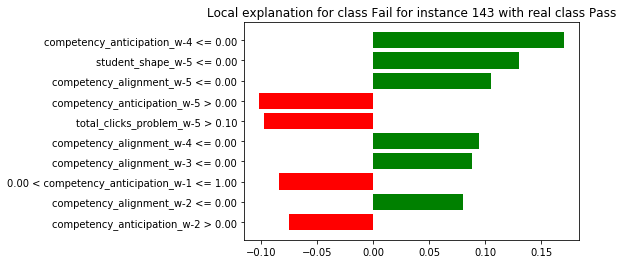

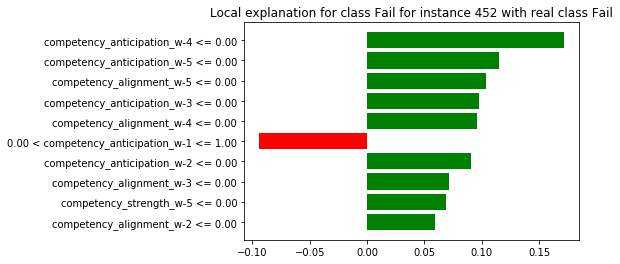

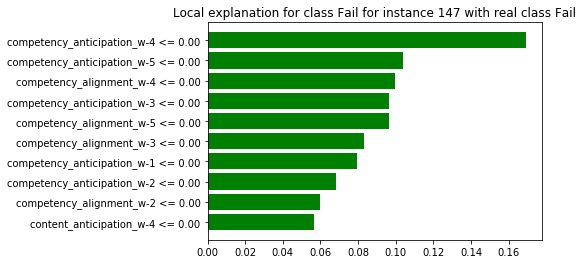

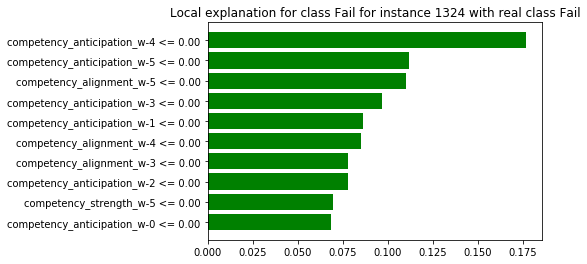

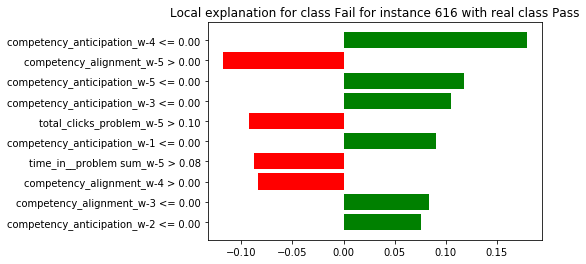

In [18]:
pyplot_all(explainers_1, instances_1, real_labels_1)

In [19]:
df_1 = DataFrame_all(explainers_1, instances_1, real_labels_1)

In [20]:
df_1.to_csv('../results/lime/spectral_clustering/lime_cluster_1.csv')

In [88]:
# df_1 = pd.read_csv('lime_cluster_1.csv', index_col=0)

In [21]:
count, top_features_type, top_features_week, top_features_type_unique, count_feature_type, top_features_week_unique, count_feature_week = preprocess_features(df_1)

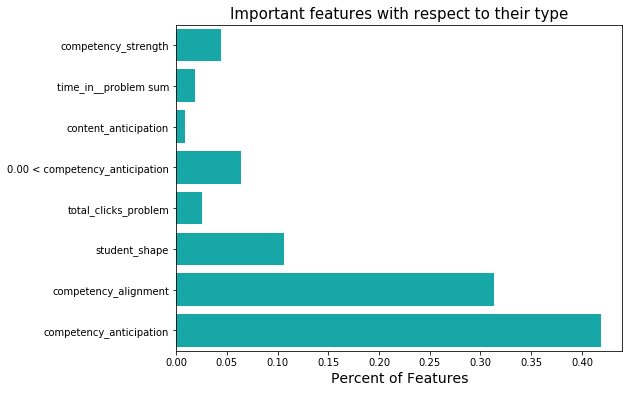

In [22]:
ind = np.argsort(count_feature_type)[::-1]
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.barplot(x=count_feature_type, y= top_features_type_unique, orient = 'h', color='c', ax =ax)
g.set_title( 'Important features with respect to their type', fontsize=15)
g.set_xlabel("Percent of Features", fontsize=14)
plt.show()

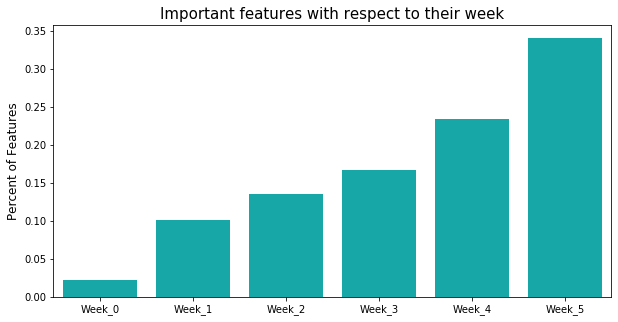

In [23]:
ind = np.argsort(count_feature_week)[::-1]
fig, ax = plt.subplots(figsize=(10, 5),facecolor='white')
g = sns.barplot(x=top_features_week_unique, y=count_feature_week, color='c',ax =ax)
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_title( 'Important features with respect to their week', fontsize=15)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Percent of Features", fontsize=12)
plt.show()

In [24]:
zero_data = np.zeros(shape=(6,len(top_features_type_unique)))
d = pd.DataFrame(zero_data, columns=top_features_type_unique)
for i,f in enumerate(top_features_type):
    d[f][int(top_features_week[i].split('_')[1])]+=count[i]

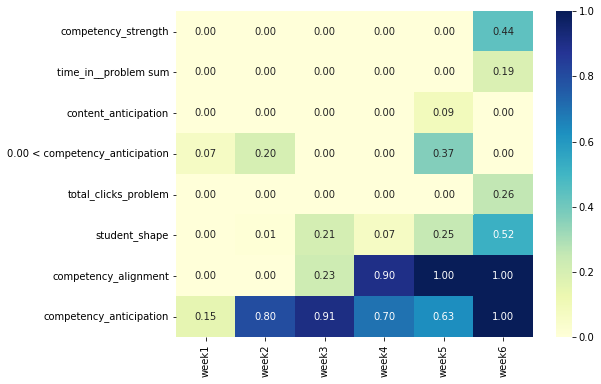

In [25]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d.values.T / len(instances_0), annot=True, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.set_xticklabels(['week'+str(i) for i in l],rotation=90)
g.set_yticklabels(top_features_type_unique,rotation=0)
plt.show()